# Import Libraries

In [1]:
# Installing natural language toolkit
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import numpy as np
import random as rand
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, f_regression, mutual_info_regression, SelectPercentile
import math as ma
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import time
print("Finished importing!")

Finished importing!


# Importing Data Sets

In [3]:
from google.colab import drive
drive.mount('/content/myDrive')

Drive already mounted at /content/myDrive; to attempt to forcibly remount, call drive.mount("/content/myDrive", force_remount=True).


In [4]:
# df_train = pd.read_csv('/content/myDrive/My Drive/ECSE_551_Machine_Learning/train.csv')
# df_test = pd.read_csv('/content/myDrive/My Drive/ECSE_551_Machine_Learning/test.csv')
# df_train = pd.read_csv('C:/Users/AlexG35/Desktop/GitHub/TextClassification/train.csv')
# df_test = pd.read_csv('C:/Users/AlexG35/Desktop/GitHub/TextClassification/test.csv')
df_train = pd.read_csv('/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/train.csv')
df_test = pd.read_csv('/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/test.csv')
# df_train = pd.read_csv('https://raw.githubusercontent.com/jhu960213/TextClassification/master/train.csv?token=AEZTLS4FRLKMK3IW2NBIKR27TQ7K6')
# df_test = ped.read_csv('https://raw.githubusercontent.com/jhu960213/TextClassification/master/test.csv?token=AEZTLS6ZNQ6KBUPIGHUS7TS7TRBXQ')
# df_train = pd.read_csv('C:/Users/karan/Desktop/Masters/Codes/CodeRemote/GitHub_codes/Under_Grad_mSpice/DP_teams/TextClassification/train.csv')
# df_test = pd.read_csv('C:/Users/karan/Desktop/Masters/Codes/CodeRemote/GitHub_codes/Under_Grad_mSpice/DP_teams/TextClassification/test.csv')


# Sample Reduction

In [5]:
# Will use the copies of the data frame dont want to change our original data frame objects when we do processing down the line
training_set = df_train
test_set = df_test["body"]

In [6]:
# Removes samples from the training set until only remaining_samples samples remain.
# the training set in is a pandas data frame object
def sampleReduction(training_set, remaining_samples=None):
  if remaining_samples == None:
    totalSamples = len(training_set)
    original_training_set = training_set.sample(totalSamples).reset_index(drop=True)
    return original_training_set
  else:
    reduced_training_set = training_set.sample(remaining_samples).reset_index(drop=True)
    return reduced_training_set

In [7]:
#--------Restrict the Number of Training Samples for Testing Purposes**---------
print("Original number of training samples: " + str(len(training_set)))
training_set = sampleReduction(training_set)
print("Reduced number of training samples: " + str(len(training_set)))
#--------Restrict the Number of Training Samples for Testing Purposes**---------

Original number of training samples: 11582
Reduced number of training samples: 11582


In [8]:
# Fixing the seed of the rand
# np.random.seed(5)

# Splitting our data into X and Y
training_set.sample(frac=1)
print("Finished shuffling our data sets")
Xtraining = training_set["body"]
ylabels = training_set["subreddit"]

print(f"Xtraining shape: {Xtraining.shape}")
print(f"ylabels shape: {Xtraining.shape}")

Finished shuffling our data sets
Xtraining shape: (11582,)
ylabels shape: (11582,)


# Visualization of Data Sets

In [9]:
# Prints out however many rows of our data
def printTrainingSet(X,numRows):
  print(f"Visualizing our sample texts:\n {X[:numRows]}")

In [10]:
printTrainingSet(Xtraining, 10)

Visualizing our sample texts:
 0    Epic is really hypocrite too. If you play Rock...
1    Please tell me them.  I have been looking for ...
2    Might just be me but does anyone else find it ...
3    My advice is to avoid SAS  it's a terrible sys...
4    Wait  so is this all the power of the X  the s...
5    Hi everyone.  I'm going to be a freshman at th...
6    Off the top of my head I would suggest Godot o...
7    I find when I'm looking for non-dnd players ev...
8    The most fundamental mechanical change is how ...
9    Well there will certainly be some high quality...
Name: body, dtype: object


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

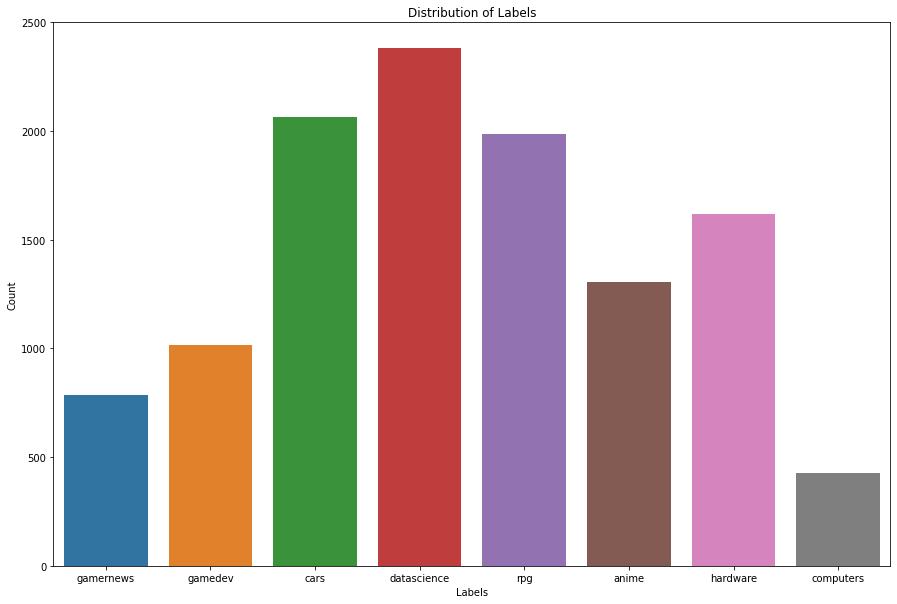

In [11]:
# print(ylabels[0:8])
# Displays the distribution of our labels 
plt.figure(figsize=(15, 10))
sns.countplot(ylabels)
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
# plt.xticks(np.arange(8), ylabels, rotation="horizontal")

# Data Preprocessing

Our own data preprocessing functions

In [12]:
#@title Dictionary of irrelevant words.
# Dictionary of irrelevant words.
# Returns true if the *LOWERCASE* word is irrelevant, else returns false.
def isIrrelevant (word):
  switcher = {
    # All pronouns and associated words
    "i": True,
    "i'll": True,
    "i'd": True,
    "i'm": True,
    "i've": True,
    "ive": True,
    "me": True,
    "myself": True,
    "you": True,
    "you'll": True,
    "you'd": True,
    "you're": True,
    "you've": True,
    "yourself": True,
    "he": True,
    "he'll": True,
    "he'd": True,
    "he's": True,
    "him": True,
    "she": True,
    "she'll": True,
    "she'd": True,
    "she's": True,
    "her": True,
    "it": True,
    "it'll": True,
    "it'd": True,
    "it's": True,
    "itself": True,
    "oneself": True,
    "we": True,
    "we'll": True,
    "we'd": True,
    "we're": True,
    "we've": True,
    "us": True,
    "ourselves": True,
    "they": True,
    "they'll": True,
    "they'd": True,
    "they're": True,
    "they've": True,
    "them": True,
    "themselves": True,            
    "everyone": True,
    "everyone's": True,
    "everybody": True,
    "everybody's": True,
    "someone": True,
    "someone's": True,
    "somebody": True,
    "somebody's": True,
    "nobody": True,
    "nobody's": True,
    "anyone": True,
    "anyone's": True,
    "everything": True,
    "everything's": True,
    "something": True,
    "something's": True,
    "nothing": True,
    "nothing's": True,
    "anything": True,
    "anything's": True,
    # All determiners and associated words
    "a": True,
    "an": True,
    "the": True,
    "this": True,
    "that": True,
    "that's": True,
    "these": True,
    "those": True,
    "my": True,
    #"mine": True,   #Omitted since mine can refer to something else
    "your": True,
    "yours": True,
    "his": True,
    "hers": True,
    "its": True,
    "our": True,
    "ours": True,
    "own": True,
    "their": True,
    "theirs": True,
    "few": True,
    "much": True,
    "many": True,
    "lot": True,
    "lots": True,
    "some": True,
    "any": True,
    "enough": True,
    "all": True,
    "both": True,
    "half": True,
    "either": True,
    "neither": True,
    "each": True,
    "every": True,
    "certain": True,
    "other": True,
    "another": True,
    "such": True,
    "several": True,
    "multiple": True,
    # "what": True,    #Dealt with later on
    "rather": True,
    "quite": True,
    # All prepositions
    "aboard": True,
    "about": True,
    "above": True,
    "across": True,
    "after": True,
    "against": True,
    "along": True,
    "amid": True,
    "amidst": True,
    "among": True,
    "amongst": True,
    "anti": True,
    "around": True,
    "as": True,
    "at": True,
    "away": True,
    "before": True,
    "behind": True,
    "below": True,
    "beneath": True,
    "beside": True,
    "besides": True,
    "between": True,
    "beyond": True,
    "but": True,
    "by": True,
    "concerning": True,
    "considering": True,
    "despite": True,
    "down": True,
    "during": True,
    "except": True,
    "excepting": True,
    "excluding": True,
    "far": True,
    "following": True,
    "for": True,
    "from": True,
    "here": True,
    "here's": True,
    "in": True,
    "inside": True,
    "into": True,
    "left": True,
    "like": True,
    "minus": True,
    "near": True,
    "of": True,
    "off": True,
    "on": True,
    "onto": True,
    "opposite": True,
    "out": True,
    "outside": True,
    "over": True,
    "past": True,
    "per": True,
    "plus": True,
    "regarding": True,
    "right": True,
    #"round": True,   #Omitted
    #"save": True,    #Omitted
    "since": True,
    "than": True,
    "there": True,
    "there's": True,
    "through": True,
    "to": True,
    "toward": True,
    "towards": True,
    "under": True,
    "underneath": True,
    "unlike": True,
    "until": True,
    "up": True,
    "upon": True,
    "versus": True,
    "via": True,
    "with": True,
    "within": True,
    "without": True,
    # Irrelevant verbs
    "may": True,
    "might": True,
    "will": True,
    "won't": True,
    "would": True,
    "wouldn't": True,
    "can": True,
    "can't": True,
    "cannot": True,
    "could": True,
    "couldn't": True,
    "should": True,
    "shouldn't": True,
    "must": True,
    "must've": True,
    "be": True,
    "being": True,
    "been": True,
    "am": True,
    "are": True,
    "aren't": True,
    "ain't": True,
    "is": True,
    "isn't": True,
    "was": True,
    "wasn't": True,
    "were": True,
    "weren't": True,
    "do": True,
    "doing": True,
    "don't": True,
    "does": True,
    "doesn't": True,
    "did": True,
    "didn't": True,
    "done": True,
    "have": True,
    "haven't": True,
    "having": True,
    "has": True,
    "hasn't": True,
    "had": True,
    "hadn't": True,
    "get": True,
    "getting": True,
    "gets": True,
    "got": True,
    "gotten": True,
    "go": True,
    "going": True,
    "gonna": True,
    "goes": True,
    "went": True,
    "gone": True,
    "make": True,
    "making": True,
    "makes": True,
    "made": True,
    "take": True,
    "taking": True,
    "takes": True,
    "took": True,
    "taken": True,
    "need": True,
    "needing": True,
    "needs": True,
    "needed": True,
    "use": True,
    "using": True,
    "uses": True,
    "used": True,
    "want": True,
    "wanna": True,
    "wanting": True,
    "wants": True,
    "let": True,
    "lets": True,
    "letting": True,
    "let's": True,
    "suppose": True,
    "supposing": True,
    "supposes": True,
    "supposed": True,
    "seem": True,
    "seeming": True,
    "seems": True,
    "seemed": True,
    "say": True,
    "saying": True,
    "says": True,
    "said": True,
    "know": True,
    "knowing": True,
    "knows": True,
    "knew": True,
    "known": True,
    "look": True,
    "looking": True,
    "looked": True,
    "think": True,
    "thinking": True,
    "thinks": True,
    "thought": True,
    "feel": True,
    "feels": True,
    "felt": True,
    "based": True,
    "put": True,
    "puts": True,
    "begin": True,
    "began": True,
    "begun": True,
    "begins": True,
    "wanted": True,
    "like": True,  
    "feel": True,
    "believe": True,
    "understand": True,
    "shall": True,
    "regard": True,
    "regards": True,
    "regarding": True,
    # Question words and associated words
    "who": True,
    "who's": True,
    "who've": True,
    "who'd": True,
    "whoever": True,
    "whoever's": True,
    "whom": True,
    "whomever": True,
    "whomever's": True,
    "whose": True,
    "whosever": True,
    "whosever's": True,
    "when": True,
    "whenever": True,
    "which": True,
    "whichever": True,
    "where": True,
    "where's": True,
    "where'd": True,
    "wherever": True,
    "why": True,
    "why's": True,
    "why'd": True,
    "whyever": True,
    "what": True,
    "what's": True,
    "whatever": True,
    "whence": True,
    "how": True,
    "how's": True,
    "how'd": True,
    "however": True,
    "whether": True,
    "whatsoever": True,
    # Connector words and irrelevant adverbs
    "and": True,
    "or": True,
    "not": True,
    "because": True,
    "also": True,
    "always": True,
    "never": True,
    "only": True,
    "really": True,
    "very": True,
    "greatly": True,
    "extremely": True,
    "somewhat": True,
    "no": True,
    "nope": True,
    "nah": True,
    "yes": True,
    "yep": True,
    "yeh": True,
    "yeah": True,
    "maybe": True,
    "perhaps": True,
    "more": True,
    "most": True,
    "less": True,
    "least": True,
    "good": True,
    "great": True,
    "well": True,
    "better": True,
    "best": True,
    "bad": True,
    "worse": True,
    "worst": True,
    "too": True,
    "thru": True,
    "though": True,
    "although": True,
    "yet": True,
    "already": True,
    "then": True,
    "even": True,
    "now": True,
    "sometimes": True,
    "still": True,
    "together": True,
    "altogether": True,
    "entirely": True,
    "fully": True,
    "entire": True,
    "whole": True,
    "completely": True,
    "utterly": True,
    "seemingly": True,
    "apparently": True,
    "clearly": True,
    "obviously": True,
    "actually": True,
    "actual": True,
    "usually": True,
    "usual": True,
    "literally": True,
    "honestly": True,
    "absolutely": True,
    "definitely": True,
    "generally": True,
    "totally": True,
    "finally": True,
    "basically": True,
    "essentially": True,
    "fundamentally": True,
    "automatically": True,
    "immediately": True,
    "necessarily": True,
    "primarily": True,
    "normally": True,
    "perfectly": True,
    "constantly": True,
    "particularly": True,
    "eventually": True,
    "hopefully": True,
    "mainly": True,
    "typically": True,
    "specifically": True,
    "differently": True,
    "appropriately": True,
    "plenty": True,
    "certainly": True,
    "unfortunately": True,
    "ultimately": True,
    "unlikely": True,
    "likely": True,
    "potentially": True,
    "fortunately": True,
    "personally": True,
    "directly": True,
    "indirectly": True,
    "nearly": True,
    "closely": True,
    "slightly": True,
    "probably": True,
    "possibly": True,
    "especially": True,
    "frequently": True,
    "thankfully": True,
    "often": True,
    "oftentimes": True,
    "seldom": True,
    "rarely": True,
    "sure": True,
    "while": True,
    "whilst": True,
    "able": True,
    "unable": True,
    "else": True,
    "ever": True,
    "once": True,
    "twice": True,
    "thrice": True,
    "almost": True,
    "again": True,
    "instead": True,
    "next": True,
    "previous": True,
    "unless": True,
    "somehow": True,
    "anyhow": True,
    "anywhere": True,
    "somewhere": True,
    "everywhere": True,
    "elsewhere": True,
    "anytime": True,
    "nowhere": True,
    "further": True,
    "anymore": True,
    "later": True,
    "ago": True,
    "ahead": True,
    "just": True,
    "same": True,
    "different": True,
    "big": True,
    "small": True,
    "little": True,
    "tiny": True,
    "large": True,
    "huge": True,
    "pretty": True,
    "mostly": True,
    "anyway": True,
    "anyways": True,
    "otherwise": True,
    "regardless": True,
    "needless": True,
    "throughout": True,
    "additionally": True,
    "moreover": True,
    "furthermore": True,
    "therefore": True,
    "thereof": True,
    "meanwhile": True,
    "likewise": True,
    "afterwards": True,
    "nice": True,
    "nicer": True,
    "nicest": True,
    "glad": True,
    "fine": True,
    # Irrelevant nouns
    "thing": True,
    "thing's": True,
    "things": True,
    "stuff": True,
    "other's": True,
    "others": True,
    "another's": True,
    "total": True,
    "true": True,
    "false": True,
    "none": True,
    "way": True,
    "kind": True,
    # Lettered numbers and order
    "zero": True,
    "zeros": True,
    "zeroes": True,
    "one": True,
    "ones": True,
    "two": True,
    "three": True,
    "four": True,
    "five": True,
    "six": True, 
    "seven": True,
    "eight": True,
    "nine": True,
    "ten": True,
    "twenty": True,
    "thirty": True,
    "forty": True,
    "fifty": True,
    "sixty": True,
    "seventy": True,
    "eighty": True,
    "ninety": True,
    "hundred": True,
    "hundreds": True,
    "thousand": True,
    "thousands": True,
    "million": True,
    "millions": True,
    "first": True,
    "last": True,
    "second": True,
    "third": True,
    "fourth": True,
    "fifth": True,
    "sixth": True,
    "seventh": True,
    "eigth": True,
    "ninth": True,
    "tenth": True,
    "firstly": True,
    "secondly": True,
    "thirdly": True,
    "lastly": True,
    # Greetings and slang
    "hello": True,
    "hi": True,
    "hey": True,
    "sup": True,
    "yo": True,
    "greetings": True,
    "please": True,
    "okay": True,
    "ok": True,
    "y'all": True,
    "lol": True,
    "rofl": True,
    "thank": True,
    "thanks": True,
    "alright": True,
    "kinda": True,
    "dont": True,
    "sorry": True,
    "idk": True,
    "tldr": True,
    "tl": True,
    "dr": True,  #This means that dr (doctor) is a bad feature because of tl;dr
    "tbh": True,
    "dude": True,
    "dudes": True,
    "tho": True,
    "aka": True,
    "plz": True,
    "pls": True,
    "bit": True,
    "don": True,
    "afaik": True,
    "wouldn": True,
    "wouldnt": True,
    "doesnt": True,
    "doesn": True,
    "didn": True, 
    "didnt": True,
    "haven": True,
    "havent": True,
    "ugh": True,
    "legit": True,
    "guess": True,
    "bullshit": True,
    "yup": True,
    "yep": True,
    "haha": True,
    "hahaha": True,
    "hahahaha": True,
    "hehe": True,
    "hehehe": True,
    "till": True,
    "sure": True,
    "soon": True,
    "nah": True,
    "meh": True,
    "imo": True,
    "imho": True,
    "ill": True,
    "hella": True,
    "chill": True,
    "btw": True,
    "bro": True,

    # Miscellaneous
    "www": True,
    "https": True,
    "http": True,
    "com": True,
    "etc": True,
    "html": True,
    "reddit": True,
    "subreddit": True,
    "subreddits": True,
    "comments": True,
    "reply": True,
    "replies": True,
    "thread": True,
    "threads": True,
    "post": True,
    "posts": True,
    "website": True,
    "websites": True,
    "web site": True,
    "web sites": True
  }
  return switcher.get(word,False)

In [13]:
#@title Dictionary of relevant characters in a word.
#@ Dictionary of relevant characters in a word.
# Dictionary of relevant characters in a word.
# Returns true if the character is a *LOWERCASE* letter, number or accepted 
# special character, else returns false.
def isAlphanumeric (char):
  switcher = {
      
    'ア': True,
    'ニ': True,
    'メ': True,
    'ら': True,
    'か': True,
    'い': True,
    '上': True,
    '手': True,
    'の': True,
    '高': True,
    '木': True,
    'さ': True,
    'ん': True,
    '一': True,
    '発': True,
    'ギ': True,
    'ャ':True,
    'グ': True,
    '仲': True,
    'が': True,
    '良': True,
    'く': True,
    'て': True,
    '羨': True,
    'ま': True,
    'し': True,
    'い': True,
    'わ': True,
    '天': True, 
    '丼': True,
    '如': True,
    '意': True, 
    '金': True,
    '箍':True,
    '棒': True,
    '虹': True,  
    '色': True,
    '西': True,  
    '游': True,
    '记': True,
    'か': True, 
    'a': True,
    'b': True,
    'c': True,
    'd': True,
    'e': True,
    'f': True,
    'g': True,
    'h': True,
    'i': True,
    'j': True,
    'k': True,
    'l': True,
    'm': True,
    'n': True,
    'o': True,
    'p': True,
    'q': True,
    'r': True,
    's': True,
    't': True,
    'u': True,
    'v': True,
    'w': True,
    'x': True,
    'y': True,
    'z': True,
    '0': True,
    '1': True,
    '2': True,
    '3': True,
    '4': True,
    '5': True,
    '6': True,
    '7': True,
    '8': True,
    '9': True,
    '\'': True,   #Apostrophe
    '$': True,
    #'@': True,    #For email addresses
    #'_': True, 
    '-': True,
    #'/': True     #For websites
  }
  return switcher.get(char,False)

In [14]:
# Joins the characters in a list of characters together to form a string.
def mergeCharacters(char_array):
  # Intialize string to ""
  s = ""

  return(s.join(char_array))

In [15]:
# Returns true if character is a number, false otherwise.
def isNumber(char):
  switcher = {
    '0': True,
    '1': True,
    '2': True,
    '3': True,
    '4': True,
    '5': True,
    '6': True,
    '7': True,
    '8': True,
    '9': True,
  }
  return switcher.get(char,False)

In [16]:
# Parses the input string and returns its words in the form of a list of strings.
def parseLine(line):
  line = line.lower()     # Converts all letters to lowercase
  char_array = list(line) # Converts the line to an list of characters
  words_array = [[]]      # List of a list of characters that for words
  words = []              # List of words
  word_idx = 0      # Index of the current word
  # Creates a list of words made out of characters (i.e. a list of lists of char).
  for char in char_array:
    if isAlphanumeric(char):
      temp = words_array[word_idx]    # temp is the current word
      temp.append(char)
      #char_idx += 1
    else:
      if words_array[word_idx]:     # True if word contains at least 1 character
        words_array.append([])      # Appending the next empty word to be filled
        word_idx += 1               # Index into the next word
  # Creates a list of words made out of strings.
  for word in words_array:
    if word:                        # If word is non-empty. Always true (hopefully) except for the last one)            
      dollar_sign = False
      contains_number = False
      letter_number = False
      for char in word:
        if char == '$':                
          dollar_sign = True
        elif contains_number and (not isNumber(char)):
          letter_number = True
        elif isNumber(char):
          contains_number = True
      if dollar_sign:
        words.append("money")       # Substitute any money amount with simply "money"
      elif letter_number:
        words.append("alphanum")    # Substitute any number with letters with "alphanum"
      elif contains_number:
        words.append("number")      # Substitute any number with simply "number"
      else:
        temp = mergeCharacters(word)
        if not isIrrelevant(temp) and len(temp) > 2:
          words.append(temp)  # Merge the characters of the word into a string
  return words

Conversion of class labels into binary numbers

In [17]:
# Convert the class labels to integers from 0 to 7 using a dictionary
def numberToLabel (num):
  switcher = {
     0:"rpg",
     1: "anime",
     2:"datascience",
     3:"hardware", 
     4:"cars",
     5:"gamernews",
     6:"gamedev",
     7:"computers"
  }
  return switcher.get(num,"Invalid class label")

In [18]:
# Convert the class labels to integers from 0 to 7 using a dictionary
def labelToNumber (label):
  switcher = {
    "rpg": 0,
    "anime": 1,
    "datascience": 2,
    "hardware": 3,
    "cars": 4,
    "gamernews": 5,
    "gamedev": 6,
    "computers": 7,
  }
  return switcher.get(label,"Invalid class label")

In [19]:
# Convert the class labels into a numpy array named Y.
# Each entry in Y should still match the corresponding row in X.
Y = np.zeros((ylabels.shape[0],1))
for i in range(0, Y.shape[0]):
  # Convert the class labels to a number between 0 and 7
  label_number = labelToNumber(ylabels[i])   
  if label_number != "Invalid class label":
    Y[i,0] = label_number
  else: 
    print("Invalid class label!")

# Reshaping our labels
# Y = np.reshape(Y,(Y.shape[0],))
print(f"Y shape as numpy: {Y.shape}")

Y shape as numpy: (11582, 1)


Lemmatization & Stemming

In [20]:
# Map the pos tag to first character that lemmatize accepts
def get_wordnet_pos(word):
  # my tag returns an upper case letter representing nouns, verbs, adverbs, etc
  """Map POS tag to first character lemmatize() accepts"""
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

In [21]:
# Create a new class for that does word tokenizing combined with word lemmatization
class MyLemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    return [self.wnl.lemmatize(t,pos =get_wordnet_pos(t)) for t in word_tokenize(doc) if t.isalpha()]

In [22]:
# Create my stemming object for mophological variants of root/base words findings
class MyStemTokenizer:
  # Constructor
  def __init__(self):
    self.myPorterStemmer = PorterStemmer()
  # It does the stemmization
  def __call__(self, document):
    return [self.myPorterStemmer.stem(j) for j in word_tokenize(document) if j.isalpha()]

In [23]:
# Get all my english stop words
myStopWords = text.ENGLISH_STOP_WORDS
myStopWords = list(myStopWords)
print(myStopWords)
myStopWords.append("_")

# #Adding more stop words to the imported list of stop words
# file_path = "/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/stopwords.txt"
# with open(file_path,mode='r') as file:
#   content = file.readlines()
#   for word in content:
#     myStopWords.append(str(word))

['either', 'con', 'due', 'name', 'whole', 'cry', 'in', 'un', 'upon', 'through', 'after', 'hers', 'nevertheless', 'system', 'twelve', 'become', 'by', 'formerly', 'must', 'out', 'who', 'would', 'hasnt', 'show', 'am', 'also', 'describe', 'couldnt', 'least', 'latterly', 'take', 'why', 'ltd', 'hereupon', 'no', 'hereafter', 'while', 'without', 'yourself', 'or', 'thence', 'to', 'he', 'call', 'from', 'has', 'became', 'thin', 'via', 'one', 'as', 'afterwards', 'amoungst', 'further', 'herself', 'may', 'except', 'beside', 'co', 'meanwhile', 'nothing', 'rather', 'eight', 'since', 'everywhere', 'across', 'although', 'enough', 'i', 'its', 'indeed', 'onto', 'under', 'ie', 'always', 'about', 'none', 'part', 'any', 'many', 'now', 'over', 'perhaps', 'were', 'anywhere', 'down', 'whereafter', 'detail', 'same', 'whose', 'me', 'thereupon', 'few', 'itself', 'elsewhere', 'should', 'these', 'serious', 'an', 're', 'not', 'well', 'a', 'other', 'what', 'whence', 'can', 'otherwise', 'therein', 'hence', 'becoming', 

In [24]:
# Getting rid of all the bad characters and words
Xtraining_list = Xtraining.to_list()
X_words1 = []
for sample in Xtraining_list:
  tmp = parseLine(sample)
  s = ' '
  s = s.join(tmp)
  X_words1.append(s)



In [25]:
# Converting the list of words back into a pandas object
Xtraining = pd.DataFrame(X_words1)
Xtraining = Xtraining[0]
print(Xtraining[0])
print(Xtraining.shape)

epic hypocrite play rocket league see greedy prices cosmetic objects skyrocketed psonyx charging money simple cosmetic object wheels white lightning
(11582,)


In [26]:
# Getting rid of all bad characters and words in test set
Xtest_list = test_set.to_list()
X_words2 = []
for sample in Xtest_list:
  tmp = parseLine(sample)
  s = ' '
  s = s.join(tmp)
  X_words2.append(s)

In [27]:
# Converting the list of test words into a pandas object
Xtest = pd.DataFrame(X_words2)
Xtest = Xtest[0]
print(Xtest[0])
print(Xtest.shape)

data scientist years experience figured people experience graduated nyu degree finance applied number jobs start finance jobs fidelity morgan stanley morgan mellon company work jobs available fidelity mellon entry level surprise jobs job morgan stanley morgan current company rejected former accepted latter office close parents house benefit starting general data scientist position financial analyst position point background stats calc coursework high school uni calendar year experience research financial sector months psychology understood common types models linear regression knn time series applied year work supported research projects local office data scientist build capability ground involved research meeting people people working hand entering data spreadsheet painstakingly hand jamming graphs supported employees teaching build spreadsheets analytics automating processes spreadsheets teaching vba helping business financial analysts prevent automated process business cases involve

# Naive Bayes Classifier

In [28]:
# Superclass for Bernouilli Naive Bayes Classifiers
class Bernoulli_NB():

    #Class constructor
    def __init__(self, alpha=0.01):
      self.num_classes = 8
      self.condProb = None
      self.priorProb = None
      self.alpha = alpha
    ####################################################################################################
    ####################################################################################################

    def set_params(self, **params):
      # self.alpha = params["alpha"]
      pass

    def get_params(self, deep=False):
      parameters = {"alpha": self.alpha}
      return parameters

    # Calculate the probability of Y = 1.
    # Returns a column vector for which the ith entry is P(Yi=1)
    # and i refers to a class label.
    def probY(self, Y):

      Y = np.reshape(Y, (Y.shape[0],1))
      num_labels = self.num_classes
      prob = np.zeros((num_labels,1))  #Probability vector P(Yi=1)

      for i in range(0,Y.shape[0]):
        # Assumption: labels are integers ranging from 0 to num_labels - 1
        for label in range(0, num_labels):
          if Y[i,0] == label:
            prob[label,0] += 1
          elif Y[i,0] > (num_labels - 1):
            print("Y at index " + str(i) + " is an invalid class label")
            break
      # Divide by the total # of labels input labels Y
      prob = prob/Y.shape[0]
      return prob

    ####################################################################################################
    ####################################################################################################
    # Calculate the probability of X = 1 given a class label Yi (number).
    # Returns a row vector for which the jth entry is P(Xj=1|Yi)
    # and j refers to a feature.
    # Note: not implemented with the bias term in mind.
    def probXGivenYi(self, X, Y, label):

      Y = np.reshape(Y, (Y.shape[0],1))
      prob = np.zeros((1,X.shape[1]))  # Conditional probability vector P(Xj=1|Yi)
      denominator = 0                  # Number of times label Yi appears in Y

      for i in range(0, X.shape[0]):
        if Y[i,0] == label:
          denominator += 1
          prob = prob + X[i,:]

      # Laplace smoothing
      if(self.alpha == 1):
        prob = prob + np.ones((1,X.shape[1]))
        denominator += 2
      else:
        prob = prob + self.alpha*np.ones((1,X.shape[1]))
        denominator += self.alpha * 2
      prob = prob/denominator
      return prob
    ####################################################################################################
    ####################################################################################################
    # Write the Bernoulli Naive  Bayes Method Here
    def fit(self, Xtrain, Y):
        Y = np.reshape(Y, (Y.shape[0],1))
        # print('Starting the fit function::::')
        t1 = time.time()
        self.condProb = np.zeros((self.num_classes,Xtrain.shape[1]))

        t2 =time.time()
        self.priorProb = self.probY(Y)
        # print('Time taken for Pior probs function:::', time.time()-t2 )

        t3 = time.time()
        for c in range(self.num_classes):
            self.condProb[c,:] = self.probXGivenYi(Xtrain, Y, c)
        # print('Time taken for Condtional Prob:::', time.time()-t3)
        # print('Total time by fit function:::', time.time()-t1 )
    ####################################################################################################
    ####################################################################################################
                            #NON OPTIMISED BERNOULLI #
    # def predict(self,Xtest):
    #
    #     predLabel = np.zeros((Xtest.shape[0],1))
    #     prosteriorProb = np.zeros((Xtest.shape[0],8))
    #
    #     for d in range(Xtest.shape[0]):
    #         for c in range(8):
    #             prosteriorProb[d,c] = np.log10(self.priorProb[c,0])
    #             for index in range(Xtest.shape[1]):
    #                 if(Xtest[d,index] == 1):
    #                     prosteriorProb[d,c] += np.log10(self.condProb[c,index])
    #                 else:
    #                     prosteriorProb[d,c] += np.log10(1 - self.condProb[c,index])
    #
    #                 # print(self.condProb[c, index])
    #
    #         predLabel[d,0] = np.argmax(prosteriorProb[d,:])
    #         # print(prosteriorProb[d, :])
    #         # print(predLabel[d,0])
    #         # if d == 5:
    #         #     return
    #
    #     return predLabel
    ####################################################################################
    ####################################################################################
                            # OPTIMISED BERNOULLI #
    def predict(self,Xtest):
        print(f'Starting the Predicting Function....')
        start_time = time.time()
        predLabel = np.zeros((Xtest.shape[0],1), dtype=int)
        prosteriorProb = np.zeros((Xtest.shape[0],self.num_classes))
        for d in range(Xtest.shape[0]):
            for c in range(self.num_classes):
                prosteriorProb[d,c] = np.log10(self.priorProb[c,0])
                # for index in range(Xtest.shape[1]):
                #     if(Xtest[d,index] == 1):
                #         prosteriorProb[d,c] += np.log10(self.condProb[c,index])
                #     else:
                #         prosteriorProb[d,c] += np.log10(1 - self.condProb[c,index])
                Z = Xtest[d,:]
                # print(Xtest.shape)
                # print(type(Xtest))
                # print(Z.shape)
                
                # print(type(Z))

                # print(sp.nonzero(Z))
                # one_ind = np.where(Z==1)[0]
                one_ind = sp.nonzero(Z)[1]
                zero_ind = np.delete(np.arange(0,Xtest.shape[0]),one_ind,0)
                row_ones = np.ones((1,zero_ind.shape[0]))
                prosteriorProb[d,c] += np.sum(np.log10(self.condProb[c,one_ind]))
                prosteriorProb[d,c] +=  np.sum(np.log10(row_ones-self.condProb[c,zero_ind]))
              
       
            predLabel[d,0] = np.argmax(prosteriorProb[d,:])
        print(f'Time taken for predict function: {time.time()-start_time}')
        return predLabel

# Ensemble Bagging

In [29]:
def featureVectorizer(myVectorizer, tfidfNormalizer, Xtraining, numFeatures):

  # Making my frequency vectors (either binary or non binary depends on CountVectorizer)
  training_vectors = myVectorizer.fit_transform(Xtraining)

  # TFIDF normalizing
  training_vectors_tfidf_normalized = tfidfNormalizer.fit_transform(training_vectors)

  # Using Sklearns function to help us select the top features
  training_vectors_tfidf_normalized_new = SelectKBest(chi2, k=numFeatures).fit_transform(training_vectors_tfidf_normalized, Y)

  # Look at feature names for both and extract and save a list of them for viewing
  myFeatures = myVectorizer.get_feature_names()
  path1 = "/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/features1.txt"
  # Writing the feaure names to a text file
  with open(path1, mode='w') as file:
    for item in myFeatures:
      file.write("%s\n" % item)

  return training_vectors_tfidf_normalized_new, myVectorizer, tfidfNormalizer

In [30]:
#
def bootstrapWithReplacement(X, Y):
  X = X.toarray()
  Xout = np.zeros((X.shape[0],X.shape[1]))
  Yout = np.zeros((Y.shape[0],Y.shape[1]))
  for i in range(0,X.shape[0]):
    rand_idx = rand.randint(0,X.shape[0]-1)
    Xout[i,:] = X[rand_idx,:]
    Yout[i,:] = Y[rand_idx,:]
  return Xout, Yout

In [31]:
# Our bootstrap ensemble classifier 
def ensembleBagging(myVectorizer, mytfidfTransformer, num_features, alpha, Xtraining, Y, Xtest, B, path):

  # feature selector from sklearn
  skLearnFeatureSelector = SelectKBest(chi2, k=num_features)

  # vectorization of our training and testing data
  vectors_train = myVectorizer.fit_transform(Xtraining)
  vectors_test = myVectorizer.transform(Xtest)

  # tfidf normalization
  vectors_train_tfidf_normalized = mytfidfTransformer.fit_transform(vectors_train)
  vectors_test_tfidf_normalized = mytfidfTransformer.transform(vectors_test)

  # selecting the top features using chi squared evaluation
  vectors_train_tfidf_normalized_new = skLearnFeatureSelector.fit_transform(vectors_train_tfidf_normalized, Y)
  vectors_test_tfidf_normalized_new = skLearnFeatureSelector.transform(vectors_test_tfidf_normalized)

  # accuracies list
  accuracies = np.zeros((1,B))

  # predicted labels for each of our classifier
  predictedLabels = np.zeros((Xtest.shape[0], B), dtype=int)
  
  for i in range(0,B):

    # instantiating a different instance of NB for classification
    nb = Bernoulli_NB(alpha=alpha)                

    # bootstrap our data (sample with replacement)
    Xresampled, Yresampled = bootstrapWithReplacement(vectors_train_tfidf_normalized_new, Y)

    # convert back frorm numpy to sparse
    Xresampled = sparse.csr_matrix(Xresampled)

    # # Run k-fold to get the model (classifier) accuracies
    # avgErrorOfThisModel, avgAccuracyOfThisModel, fold_Accuracy_Dict = run_K_Fold_CrossValidation(Xresampled, Yresampled, nb, numFolds=3)
    # # accuracies.append(avgAccuracyOfThisModel)
    # accuracies[0,i] = avgAccuracyOfThisModel

    # Evaluating using our classifier
    nb.fit(Xresampled, Yresampled)
    tmp = nb.predict(vectors_test_tfidf_normalized_new)
    predictedLabels[:,i] = np.reshape(tmp, (tmp.shape[0],))

  # Majority voting
  finalLabel = np.zeros((predictedLabels.shape[0], 1))
  for i in range(0, predictedLabels.shape[0]):
    frequencies = np.zeros((1,8), dtype=int)
    for j in range(B):
      frequencies[0,predictedLabels[i,j]] += 1
    max = np.max(frequencies)
    idx = [] # Classifier indices
    for x in range(0,frequencies.shape[1]):
      if frequencies[0,x] == max:
        idx.append(x) 
    if len(idx) > 1:
      print(idx)
      finalLabel[i,0] = idx[1]
    else:
      finalLabel[i,0] = idx[0]

  
  # Convert number labels back into string labels
  predictedLabelsStringFormat = []
  for labelNum in finalLabel:
    predictedLabelsStringFormat.append(numberToLabel(int(labelNum[0])))

  print(f"Length of predicted list: {len(predictedLabelsStringFormat)}")
  # print(predictedLabelsStringFormat)
  # Convert from list to pandas data frame
  dfPredicted = pd.DataFrame(predictedLabelsStringFormat, columns=['subreddit'])
  # print(dfPredicted)
  dfPredicted.to_csv(path)
  return finalLabel


# Pipeline & GridsearchCV

SKLearn SVC Tunning

In [32]:
# Defining my pipeline parameters for my gridsearchCV to tweak at run time
pipeline_parameters = {
    "classifier__max_iter": [500000],
    "classifier__multi_class": ['ovr', 'crammer_singer'],
    "classifier__tol": [1e-4],
    "classifier__C": [1.0],
    "classifier__dual": [True],
    "classifier__loss": ['squared_hinge'],
    # "classifier__penalty": ['l1', 'l2'],
    "countVectorizer__binary": [False],
    "countVectorizer__max_df": [1.0],
    "countVectorizer__min_df": [0.0],
    "countVectorizer__stop_words": [myStopWords],
    "countVectorizer__max_features": [5500],
    "countVectorizer__ngram_range":[(1,1)],
    "countVectorizer__tokenizer": [MyStemTokenizer(), MyLemmaTokenizer()],
    "normalizer__norm": ['l2']
}

# adaboostCLF = AdaBoostClassifier(base_estimator=Bernoulli_NB(), n_estimators=8, random_state=0, algorithm='SAMME')

# Making my pipeline to have these preprocessing functions
myPipe = Pipeline(
    # [('countVectorizer', CountVectorizer()), ('classifier', LinearSVC())]
    [('countVectorizer', CountVectorizer()), ('normalizer', Normalizer()), ('classifier', LinearSVC())]
)

# Making a grid search object in order to optimize our parameters
myGridSearch = GridSearchCV(myPipe, param_grid=pipeline_parameters, scoring="accuracy", n_jobs=-2, verbose=1)
print("Performing grid search...")
print("Pipeline: ", [name for name, _ in myPipe.steps])
t0 = time.time()
Ygridsearch = np.reshape(Y, (Y.shape[0],))
print(Xtraining.shape)
myGridSearch.fit(Xtraining, Ygridsearch)
print("Finished in %0.3fs" % (time.time() - t0))
print("\n")

In [33]:
print("Best score: %0.3f" % myGridSearch.best_score_)
print("Best parameters set:")
bestParameters = myGridSearch.best_estimator_.get_params()
# print(bestParameters)
for paramName in sorted(bestParameters.keys()):
  print("\t%s: %r" % (paramName, bestParameters[paramName]))

SKLearn LinearSVC Tuning

In [34]:
# Defining my pipeline parameters for my gridsearchCV to tweak at run time
pipeline_parameters = {
    "classifier__max_iter": [10000000],
    "classifier__multi_class": ['ovr'],
    "classifier__tol": [1e-4],
    "classifier__C": [1.0],
    "classifier__dual": [True],
    "classifier__loss": ['squared_hinge'],
    "classifier__penalty": ['l2'],
    "countVectorizer__binary": [False],
    "countVectorizer__max_df": [1.0],
    "countVectorizer__min_df": [0.0],
    "countVectorizer__stop_words": [myStopWords],
    "countVectorizer__max_features": [15000],
    "countVectorizer__ngram_range":[(1,1)],
    # "countVectorizer__tokenizer": [MyStemTokenizer()],
    "normalizer__norm": ['l2']
}

# adaboostCLF = AdaBoostClassifier(base_estimator=Bernoulli_NB(), n_estimators=8, random_state=0, algorithm='SAMME')

# Making my pipeline to have these preprocessing functions
myPipe = Pipeline(
    # [('countVectorizer', CountVectorizer()), ('classifier', LinearSVC())]
    [('countVectorizer', CountVectorizer()), ('normalizer', Normalizer()), ('classifier', LinearSVC())]
)

# Making a grid search object in order to optimize our parameters
myGridSearch = GridSearchCV(myPipe, param_grid=pipeline_parameters, scoring="accuracy", n_jobs=-2, verbose=1)
print("Performing grid search...")
print("Pipeline: ", [name for name, _ in myPipe.steps])
t0 = time.time()
Ygridsearch = np.reshape(Y, (Y.shape[0],))
print(Xtraining.shape)
myGridSearch.fit(Xtraining, Ygridsearch)
print("Finished in %0.3fs" % (time.time() - t0))
print("\n")

Performing grid search...
Pipeline:  ['countVectorizer', 'normalizer', 'classifier']
(11582,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    4.1s finished


Finished in 4.995s




In [35]:
print("Best score: %0.3f" % myGridSearch.best_score_)
print("Best parameters set:")
bestParameters = myGridSearch.best_estimator_.get_params()
# print(bestParameters)
for paramName in sorted(bestParameters.keys()):
  print("\t%s: %r" % (paramName, bestParameters[paramName]))

Sklearn Multinomial NB Tuning

In [36]:
# Defining my pipeline parameters for my gridsearchCV to tweak at run time
pipeline_Params_Multi_Bayes = {
    "classifier__alpha": [0.06, 0.04, 0.02],
    "countVectorizer__binary": [False],
    "countVectorizer__max_df": [0.1],
    "countVectorizer__min_df": [1],
    "countVectorizer__stop_words": [myStopWords],
    "countVectorizer__max_features": [5000],
    "countVectorizer__ngram_range":[(1,1)],
    "countVectorizer__tokenizer": [MyStemTokenizer()],
    # "normalizer__norm": ['l2','l1']
}

# adaboostCLF = AdaBoostClassifier(base_estimator=Bernoulli_NB(), n_estimators=8, random_state=0, algorithm='SAMME')

# Making my pipeline to have these preprocessing functions
myPipeMultiBayes = Pipeline(
    # [('countVectorizer', CountVectorizer()), ('classifier', Bernoulli_NB())]
    [('countVectorizer', CountVectorizer()), ('classifier', MultinomialNB())]
)

# Making a grid search object in order to optimize our parameters
myGridSearchMultiBayes = GridSearchCV(myPipeMultiBayes, param_grid=pipeline_Params_Multi_Bayes, scoring="accuracy", n_jobs=-2, verbose=1)
# Xnew = SelectKBest(chi2, k=5000).fit_transform(Xtraining, Y)
print("Performing grid search...")
print("Pipeline: ", [name for name, _ in myPipeMultiBayes.steps])
t0 = time.time()
YMultiBayes = np.reshape(Y, (Y.shape[0],))
myGridSearchMultiBayes.fit(Xtraining, YMultiBayes)
print("Finished in %0.3fs" % (time.time() - t0))
print("\n")

In [37]:
print("Best score: %0.3f" % myGridSearchMultiBayes.best_score_)
print("Best parameters set:")
bestParameters = myGridSearchMultiBayes.best_estimator_.get_params()
# print(bestParameters)
for paramName in sorted(bestParameters.keys()):
  print("\t%s: %r" % (paramName, bestParameters[paramName]))

Bernoulli Naive Bayes Tunning

In [38]:
# Defining my pipeline parameters for my gridsearchCV to tweak at run time
pipeline_parameters = {
    "classifier__alpha": [0.01],
    "countVectorizer__binary": [False],
    "countVectorizer__max_df": [1.0],
    "countVectorizer__min_df": [0.0],
    "countVectorizer__stop_words": [myStopWords],
    "countVectorizer__max_features": [8000],
    "countVectorizer__ngram_range":[(1,1)],
    # "countVectorizer__tokenizer": [MyStemTokenizer()]
    # "normalizer__norm": ['l2','l1']
}

# adaboostCLF = AdaBoostClassifier(base_estimator=Bernoulli_NB(), n_estimators=8, random_state=0, algorithm='SAMME')

# Making my pipeline to have these preprocessing functions
myPipe = Pipeline(
    [('countVectorizer', CountVectorizer()), ('tfidf', TfidfTransformer()), ('classifier', Bernoulli_NB())]
    # [('countVectorizer', CountVectorizer()), ('normalizer', Normalizer()), ('classifier', Bernoulli_NB(8))]
)

# Making a grid search object in order to optimize our parameters
myGridSearch = GridSearchCV(myPipe, param_grid=pipeline_parameters, scoring="accuracy", n_jobs=-2, verbose=1)
# Xnew = SelectKBest(chi2, k=5000).fit_transform(Xtraining, Y)
print("Performing grid search...")
print("Pipeline: ", [name for name, _ in myPipe.steps])
t0 = time.time()
# Ygridsearch = np.reshape(Y, (Y.shape[0],))
print(Xtraining.shape)
myGridSearch.fit(Xtraining, Y)
print("Finished in %0.3fs" % (time.time() - t0))
print("\n")

In [39]:
print("Best score: %0.3f" % myGridSearch.best_score_)
print("Best parameters set:")
bestParameters = myGridSearch.best_estimator_.get_params()
# print(bestParameters)
for paramName in sorted(bestParameters.keys()):
  print("\t%s: %r" % (paramName, bestParameters[paramName]))

# K-Fold Cross Validation

In [40]:
# K-Fold Cross Validation function
def run_K_Fold_CrossValidation(X, Y, classifier, numFolds=None):

    # # Convert
    # X = X.toarray()

    """Starting K-Fold Cross Validation"""
    # Create a dictionary to hold our fold accuracies
    fold_Accuracy_Dict = {}

    # Create sklearn's K-Fold instance
    kf = KFold(n_splits=numFolds)

    # Find out how many splitting iterations
    print(f"Number of splitting iterations: {kf.get_n_splits(Y)}\n")
    # TO UPDATE: print(f"Number of splitting iterations: {kf.get_n_splits(Y)}\n")

    # Fold Iteration count
    foldCount = 0

    # Fold error sum tracker
    foldErrorSum = 0

    # Fold accuracy tracker
    foldAccuracySum = 0

    # K-Fold loop
    for training_indices, validation_indices in kf.split(X):
    # TO UPDATE: for training_indices, validation_indices in kf.split(Y):

        print(f"Starting fold {foldCount + 1}.....")
        # print("Training: ", training_indices, "Validation: ", validation_indices)

        curFoldTrainingLabels = None
        curFoldValidationLabels = None
        curFoldTraining = None
        curFoldValidation = None
        # If we are using an sklearn classifier need to do this
        if (Y.shape == (Y.shape[0],)):
          curFoldTrainingLabels = Y[training_indices]
          curFoldValidationLabels = Y[validation_indices]
          curFoldTraining = X[training_indices,:]
          curFoldValidation = X[validation_indices,:]
        else:
          # Slicing our data to get current training and current validation sets
          curFoldTraining = X[training_indices,:]
          curFoldTrainingLabels = Y[training_indices,:]
          curFoldValidation = X[validation_indices,:]
          curFoldValidationLabels = Y[validation_indices,:]

        # print("Current fold training: \n", curFoldTraining) # if you want to see the sliced array for training
        print(f"Current fold training shape: {curFoldTraining.shape}")
        # print("Current fold validation: \n", curFoldValidation) # if you want to see the sliced array for validation
        print(f"Current fold validation shape: {curFoldValidation.shape}")

        # Fit our model with training
        """TODO: use our naive bayes classifier's fit function to fit our model to our training set"""
        classifier.fit(curFoldTraining, curFoldTrainingLabels)
        # TO UPDATE: classifier.fit(Xtrain, curFoldTrainingLabels)

        # Predict the labels here
        """TODO: use our predict function to predict the labels on the validation set"""
        curFoldPredictedLabels = classifier.predict(curFoldValidation)

        # Calculate accuracy for this fold
        """TODO: find accuracy"""
        count = 0
        for i in range(0, curFoldPredictedLabels.shape[0]):
            if curFoldValidationLabels[i] == curFoldPredictedLabels[i]:
                count += 1
        currentFoldAccuracy = (count/curFoldPredictedLabels.shape[0])*100
        print(f"Accuracy for fold {foldCount + 1}: {currentFoldAccuracy}%\n")


        # Add the accuracy of this fold to the dictionary
        fold_Accuracy_Dict[str(foldCount + 1)] = float(currentFoldAccuracy)

        # Update fold error tracker & fold accuracy tracker
        foldErrorSum = foldErrorSum + (100.0 - currentFoldAccuracy)
        foldAccuracySum = foldAccuracySum + currentFoldAccuracy

        # Update fold number
        foldCount += 1

    # Graph the fold accuracies with the dictionary
    plt.figure(figsize=(7,7))
    plt.bar(fold_Accuracy_Dict.keys(), fold_Accuracy_Dict.values(), 0.3, color='b')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy %')
    plt.title("K-Fold Accuracy Distribution of Current Model")
    plt.show()

    # Display this model's avg accuracy for the K-Fold
    avgAccuracyOfThisModel = float(float(foldAccuracySum)/float(foldCount))
    print(f"\nAvg accuracy for this model is: {avgAccuracyOfThisModel} %")

    # Display this model's avg error for the K-Fold
    avgErrorOfThisModel = float(float(foldErrorSum)/float(foldCount))
    print(f"Avg error for this model is: {avgErrorOfThisModel} %\n")

    # Returning the avg error, fold accuracy dictionary, and model accuracy
    return avgErrorOfThisModel, avgAccuracyOfThisModel, fold_Accuracy_Dict

# Selected Pipeline & Estimator

Pipeline Multinomial Naive Bayes

In [41]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# Now select our best features based on chi squared evaluation 
training_vectors4_normalized_new = SelectKBest(chi2, k=7500).fit_transform(training_vectors4_normalized, Y)
training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8500).fit_transform(training_vectors4_tfidf_normalized, Y)

Pipeline LinearSVC

In [42]:
# Vectorizer object for linear svc
myVectorizer3 = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer3 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer3 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors3 = myVectorizer3.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors3_tfidf_normalized = tfidfNormalizer3.fit_transform(training_vectors3)
training_vectors3_normalized = normalizer3.fit_transform(training_vectors3)

# Now select our best features based on chi squared evaluation 
training_vectors3_normalized_new = SelectKBest(chi2, k=15000).fit_transform(training_vectors3_normalized, Y)
training_vectors3_tfidf_normalized_new = SelectKBest(chi2, k=15000).fit_transform(training_vectors3_tfidf_normalized, Y)


Pipeline Bernoulli Naive Bayes

In [43]:
# My selected feature vectorization paraemeters and instance
# Keep in mind to have stemming when predicting on test set
# tokenizer=MyStemTokenizer()
myVectorizer1 = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer1 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Making my training binary vectors
training_vectors1 = myVectorizer1.fit_transform(Xtraining)

# TFIDF normalizing
training_vectors1_tfidf_normalized = tfidfNormalizer1.fit_transform(training_vectors1)

# Using Sklearns function to help us select the top features
training_vectors1_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors1_tfidf_normalized, Y)

# Look at feature names for both and extract and save a list of them for viewing
myFeatures1 = myVectorizer1.get_feature_names()
path = "/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/features.txt"
# Writing the feaure names to a text file
with open(path, mode='w') as file:
  for item in myFeatures1:
    file.write("%s\n" % item)
print("Finished writing our feature names to the text files for viewing!")

Finished writing our feature names to the text files for viewing!


In [44]:
# myVectorizer = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)
# mytfidfTransformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
# path = "/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/ensembleOut.csv"

# # split into trianing and val (1 fold for our kfold algorithm)
# Xtr = Xtraining[0:9264,]
# Xt = Xtraining[9265:11581,]
# Ytr = np.reshape(Y[0:9264,0], (Y[0:9264,0].shape[0],1))
# Yt = Y[9265:11581,0]

# # Trying to see 
# # ensembleBagging(myVectorizer, mytfidfTransformer, 8000, 0.01, Xtraining, Y, Xtest, 10, path)
# finalLabel = ensembleBagging(myVectorizer, mytfidfTransformer, 8000, 0.01, Xtr, Ytr, Xt, 10, path)
# count = 0
# for i in range(finalLabel.shape[0]):
#   if (finalLabel[i] == Yt[i]):
#     count += 1

# print(f"Ensemble accuracy: {(count/finalLabel.shape[0])*100}")




# Feature Selection Evaluations

Various Feature Selection Methods including MUTUAL INFORMATION for different classifiers 



In [45]:
# My selected feature vectorization paraemeters and instance
# Keep in mind to have stemming when predicting on test set
# tokenizer=MyStemTokenizer()
myVectorizer = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Making my training binary vectors
training_vectors = myVectorizer.fit_transform(Xtraining)

# TFIDF normalizing
training_vectors_tfidf_normalized = tfidfNormalizer.fit_transform(training_vectors)

# Using Sklearns feature selection functions to help us select the top features
featureSelectionMethods = [chi2, f_classif, mutual_info_classif, f_regression, mutual_info_regression]
accuracyList = []
for selectionMethod in featureSelectionMethods:
  print(f"Starting: {str(selectionMethod)}.......")
  training_vectors_tfidf_normalized_new = SelectKBest(score_func=selectionMethod, k=8000).fit_transform(training_vectors_tfidf_normalized, np.ravel(Y))
  _,avgAccuracy,_ = run_K_Fold_CrossValidation(training_vectors_tfidf_normalized_new, Y, Bernoulli_NB(alpha=0.01), numFolds=5)
  accuracyList.append(avgAccuracy)


In [46]:
featureSelectionNames = ["chi2", "f_classif", "mutual_info_classif", "f_regression", "mutual_info_regression"]
plt.figure(figsize=(8,8))
plt.plot(featureSelectionNames, accuracyList)
plt.title("Naive Bayes Feature Selection Method Tunning with SelectKBest")
plt.xlabel("Feature Selection Method")
plt.ylabel("Average Model Accuracy")
plt.show()

Bernouilli Naive Bayes & Best Pipeline & Various Feature Selection Methods & SelectPercentile

In [47]:
# My selected feature vectorization paraemeters and instance
# Keep in mind to have stemming when predicting on test set
# tokenizer=MyStemTokenizer()
myVectorizer = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Making my training binary vectors
training_vectors = myVectorizer.fit_transform(Xtraining)

# TFIDF normalizing
training_vectors_tfidf_normalized = tfidfNormalizer.fit_transform(training_vectors)

# Using Sklearns feature selection functions to help us select the top features
featureSelectionMethods = [chi2, f_classif, mutual_info_classif, f_regression]
accuracyList = []
for selectionMethod in featureSelectionMethods:
  print(f"Starting: {str(selectionMethod)}.......")
  training_vectors_tfidf_normalized_new = SelectPercentile(score_func=selectionMethod, percentile=25).fit_transform(training_vectors_tfidf_normalized, np.ravel(Y))
  _,avgAccuracy,_ = run_K_Fold_CrossValidation(training_vectors_tfidf_normalized_new, Y, Bernoulli_NB(alpha=0.01), numFolds=5)
  accuracyList.append(avgAccuracy)



In [48]:
featureSelectionNames = ["chi2", "f_classif", "mutual_info_classif", "f_regression"]
# Plotting feature selection methods vs accuracy 
plt.figure(figsize=(8,8))
plt.plot(featureSelectionNames, accuracyList)
plt.title("Naive Bayes Feature Selection Method Tunning with SelectPercentile")
plt.xlabel("Feature Selection Method")
plt.ylabel("Average Model Accuracy")
plt.show()

# SKLearn Ensemble Bagging

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8500)
Current fold validation shape: (2317, 8500)
Accuracy for fold 1: 90.59128182995254%

Starting fold 2.....
Current fold training shape: (9265, 8500)
Current fold validation shape: (2317, 8500)
Accuracy for fold 2: 91.36814846784635%

Starting fold 3.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 3: 91.53713298791018%

Starting fold 4.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 4: 91.83937823834198%

Starting fold 5.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 5: 92.14162348877375%



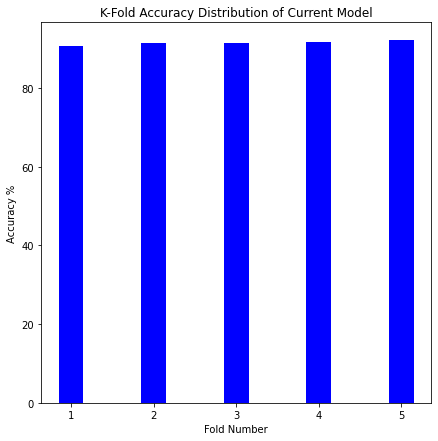


Avg accuracy for this model is: 91.49551300256495 %
Avg error for this model is: 8.504486997435041 %



(8.504486997435041,
 91.49551300256495,
 {'1': 90.59128182995254,
  '2': 91.36814846784635,
  '3': 91.53713298791018,
  '4': 91.83937823834198,
  '5': 92.14162348877375})

In [49]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# Now select our best features based on chi squared evaluation 
training_vectors4_normalized_new = SelectKBest(chi2, k=7500).fit_transform(training_vectors4_normalized, Y)
training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8500).fit_transform(training_vectors4_tfidf_normalized, Y)

# Defining ensemble classifier from sklearn
clf2 = BaggingClassifier(base_estimator=MultinomialNB(alpha=0.02, fit_prior=False), n_estimators=20, random_state=0)

# Run k fold cross validation
run_K_Fold_CrossValidation(training_vectors4_tfidf_normalized_new, np.ravel(Y), clf2, numFolds=5)


Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.128404378890991
Starting the Predicting Function....
Time taken for predict function: 6.1150126457214355
Starting the Predicting Function....
Time taken for predict function: 6.0943334102630615
Starting the Predicting Function....
Time taken for predict function: 6.09052848815918
Starting the Predicting Function....
Time taken for predict function: 6.024214744567871
Starting the Predicting Function....
Time taken for predict function: 6.047936916351318
Starting the Predicting Function....
Time taken for predict function: 6.1270318031311035
Starting the Predicting Function....
Time taken for predict function: 6.08565354347229
Starting the Predicting Function....
Time taken for predict function: 6.10057258605957
Starting the Predicting Function....
Time taken for predict function: 6.089900970458984
Starting the Predicting Function....
Time taken for predict function: 6.091604232788086
Starting the Predicting Function....
Time taken for predict function:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.1360251903533936
Starting the Predicting Function....
Time taken for predict function: 6.098041534423828
Starting the Predicting Function....
Time taken for predict function: 6.089860200881958
Starting the Predicting Function....
Time taken for predict function: 6.05401873588562
Starting the Predicting Function....
Time taken for predict function: 6.082384347915649
Starting the Predicting Function....
Time taken for predict function: 6.041102409362793
Starting the Predicting Function....
Time taken for predict function: 6.089333534240723
Starting the Predicting Function....
Time taken for predict function: 6.0588459968566895
Starting the Predicting Function....
Time taken for predict function: 6.144900321960449
Starting the Predicting Function....
Time taken for predict function: 6.0622899532318115
Starting the Predicting Function....
Time taken for predict function: 6.063958168029785
Starting the Predicting Function....
Time taken for predict functio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.081785678863525
Starting the Predicting Function....
Time taken for predict function: 6.0773375034332275
Starting the Predicting Function....
Time taken for predict function: 6.063917636871338
Starting the Predicting Function....
Time taken for predict function: 6.08913254737854
Starting the Predicting Function....
Time taken for predict function: 6.092252492904663
Starting the Predicting Function....
Time taken for predict function: 6.091034173965454
Starting the Predicting Function....
Time taken for predict function: 6.1383256912231445
Starting the Predicting Function....
Time taken for predict function: 6.074397563934326
Starting the Predicting Function....
Time taken for predict function: 6.089242458343506
Starting the Predicting Function....
Time taken for predict function: 6.095434904098511
Starting the Predicting Function....
Time taken for predict function: 6.085680961608887
Starting the Predicting Function....
Time taken for predict function

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.0894694328308105
Starting the Predicting Function....
Time taken for predict function: 6.104656934738159
Starting the Predicting Function....
Time taken for predict function: 6.087350845336914
Starting the Predicting Function....
Time taken for predict function: 6.0806779861450195
Starting the Predicting Function....
Time taken for predict function: 6.12214732170105
Starting the Predicting Function....
Time taken for predict function: 6.127332448959351
Starting the Predicting Function....
Time taken for predict function: 6.138596773147583
Starting the Predicting Function....
Time taken for predict function: 6.0524208545684814
Starting the Predicting Function....
Time taken for predict function: 6.081993341445923
Starting the Predicting Function....
Time taken for predict function: 6.054534435272217
Starting the Predicting Function....
Time taken for predict function: 6.074815511703491
Starting the Predicting Function....
Time taken for predict functio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.0919153690338135
Starting the Predicting Function....
Time taken for predict function: 6.095502138137817
Starting the Predicting Function....
Time taken for predict function: 6.093400239944458
Starting the Predicting Function....
Time taken for predict function: 6.07521653175354
Starting the Predicting Function....
Time taken for predict function: 6.035213232040405
Starting the Predicting Function....
Time taken for predict function: 6.050443410873413
Starting the Predicting Function....
Time taken for predict function: 6.093638181686401
Starting the Predicting Function....
Time taken for predict function: 6.102128505706787
Starting the Predicting Function....
Time taken for predict function: 6.052196979522705
Starting the Predicting Function....
Time taken for predict function: 6.0340495109558105
Starting the Predicting Function....
Time taken for predict function: 6.086772918701172
Starting the Predicting Function....
Time taken for predict function

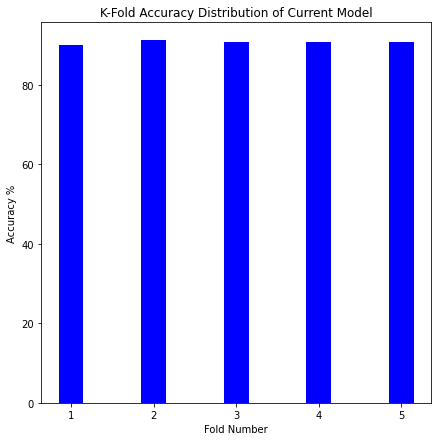


Avg accuracy for this model is: 90.72700986848727 %
Avg error for this model is: 9.272990131512746 %



(9.272990131512746,
 90.72700986848727,
 {'1': 89.98705222270176,
  '2': 91.23867069486404,
  '3': 90.75993091537133,
  '4': 90.75993091537133,
  '5': 90.88946459412782})

In [50]:
# My selected feature vectorization paraemeters and instance
# Keep in mind to have stemming when predicting on test set
# tokenizer=MyStemTokenizer()
myVectorizer1 = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer1 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Making my training binary vectors
training_vectors1 = myVectorizer1.fit_transform(Xtraining)

# TFIDF normalizing
training_vectors1_tfidf_normalized = tfidfNormalizer1.fit_transform(training_vectors1)

# Using Sklearns function to help us select the top features
training_vectors1_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors1_tfidf_normalized, Y)

# Defining ensemble classifier from sklearn
clf1 = BaggingClassifier(base_estimator=Bernoulli_NB(alpha=0.01), n_estimators=20, random_state=0)

# Run k fold cross validation
run_K_Fold_CrossValidation(training_vectors1_tfidf_normalized_new, np.ravel(Y), clf1, numFolds=5)

Classifier Instances

In [51]:
# Instantiating our classifier instances
nb1 = Bernoulli_NB(0.01)
nb2 = Bernoulli_NB(0.05)
linearsvc = LinearSVC(max_iter=1000000)
mnb = MultinomialNB(alpha=0.02, fit_prior=False)

1) K-Fold Cross Validation: SKLearn Feature Selection & Max_features = None & Bernoulli NB & TFIDF Transfromer normalized & Binary=False







Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.233243227005005
Accuracy for fold 1: 89.81441519205869%

Starting fold 2.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.241454124450684
Accuracy for fold 2: 90.89339663357791%

Starting fold 3.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.200391054153442
Accuracy for fold 3: 90.88946459412782%

Starting fold 4.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.1869494915008545
Accuracy for fold 4: 90.80310880829016%

Starting fold 5.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.190799951553345
Accuracy for fold 5: 91.10535405872193%



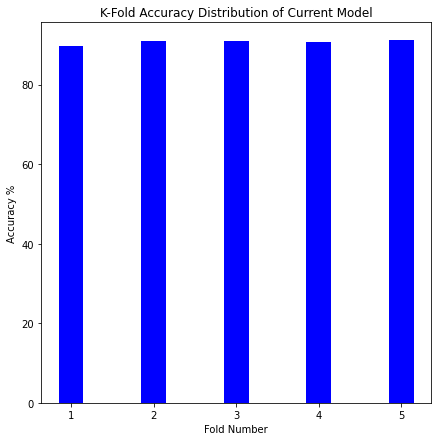


Avg accuracy for this model is: 90.7011478573553 %
Avg error for this model is: 9.2988521426447 %



(9.2988521426447,
 90.7011478573553,
 {'1': 89.81441519205869,
  '2': 90.89339663357791,
  '3': 90.88946459412782,
  '4': 90.80310880829016,
  '5': 91.10535405872193})

In [52]:
# # Run our K_fold to see what our training accuracy is like
run_K_Fold_CrossValidation(training_vectors1_tfidf_normalized_new, Y, nb1, numFolds=5)

2) K-Fold Cross Validation: SKLearn Feature Selection & Max_features = None & LinearSVC & TFIDF Transfromer normalized & Binary=False

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 15000)
Current fold validation shape: (2317, 15000)
Accuracy for fold 1: 88.9943892965041%

Starting fold 2.....
Current fold training shape: (9265, 15000)
Current fold validation shape: (2317, 15000)
Accuracy for fold 2: 89.51230038843332%

Starting fold 3.....
Current fold training shape: (9266, 15000)
Current fold validation shape: (2316, 15000)
Accuracy for fold 3: 90.02590673575129%

Starting fold 4.....
Current fold training shape: (9266, 15000)
Current fold validation shape: (2316, 15000)
Accuracy for fold 4: 88.60103626943005%

Starting fold 5.....
Current fold training shape: (9266, 15000)
Current fold validation shape: (2316, 15000)
Accuracy for fold 5: 89.59412780656304%



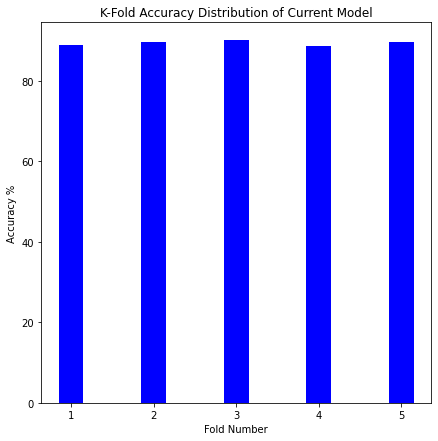


Avg accuracy for this model is: 89.34555209933636 %
Avg error for this model is: 10.65444790066364 %



(10.65444790066364,
 89.34555209933636,
 {'1': 88.9943892965041,
  '2': 89.51230038843332,
  '3': 90.02590673575129,
  '4': 88.60103626943005,
  '5': 89.59412780656304})

In [53]:
Ysvc = np.reshape(Y, (Y.shape[0],))
run_K_Fold_CrossValidation(training_vectors3_tfidf_normalized_new, Ysvc, linearsvc, numFolds=5)

3) K-Fold Cross Validation: SKLearn Feature Selection & 
Max_features = None & Multinomial Naive Bayes & TFIDF Transfromer normalized & Binary=False

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8500)
Current fold validation shape: (2317, 8500)
Accuracy for fold 1: 90.20284851100561%

Starting fold 2.....
Current fold training shape: (9265, 8500)
Current fold validation shape: (2317, 8500)
Accuracy for fold 2: 90.85023737591713%

Starting fold 3.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 3: 91.75302245250433%

Starting fold 4.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 4: 91.66666666666666%

Starting fold 5.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 5: 91.66666666666666%



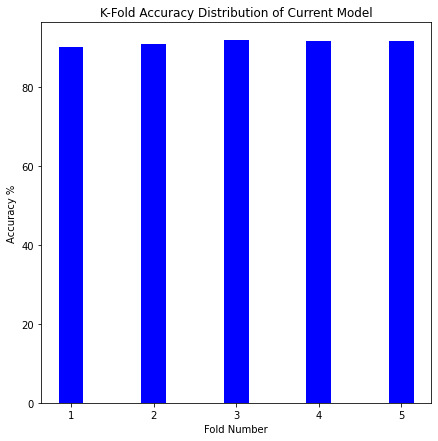


Avg accuracy for this model is: 91.22788833455206 %
Avg error for this model is: 8.772111665447923 %



(8.772111665447923,
 91.22788833455206,
 {'1': 90.20284851100561,
  '2': 90.85023737591713,
  '3': 91.75302245250433,
  '4': 91.66666666666666,
  '5': 91.66666666666666})

In [54]:
Ymnb = np.reshape(Y, (Y.shape[0],))
run_K_Fold_CrossValidation(training_vectors4_tfidf_normalized_new, Ymnb, mnb, numFolds=5)

4) K-Fold Cross Validation: SKLearn Feature Selection & Max_features = None & Multinomial Naive Bayes with Normalizer() & Binary=False



Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 7500)
Current fold validation shape: (2317, 7500)
Accuracy for fold 1: 90.28916702632715%

Starting fold 2.....
Current fold training shape: (9265, 7500)
Current fold validation shape: (2317, 7500)
Accuracy for fold 2: 91.06603366422098%

Starting fold 3.....
Current fold training shape: (9266, 7500)
Current fold validation shape: (2316, 7500)
Accuracy for fold 3: 91.58031088082902%

Starting fold 4.....
Current fold training shape: (9266, 7500)
Current fold validation shape: (2316, 7500)
Accuracy for fold 4: 91.66666666666666%

Starting fold 5.....
Current fold training shape: (9266, 7500)
Current fold validation shape: (2316, 7500)
Accuracy for fold 5: 91.58031088082902%



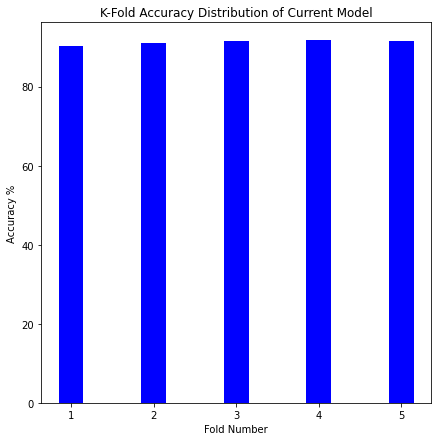


Avg accuracy for this model is: 91.23649782377457 %
Avg error for this model is: 8.763502176225435 %



(8.763502176225435,
 91.23649782377457,
 {'1': 90.28916702632715,
  '2': 91.06603366422098,
  '3': 91.58031088082902,
  '4': 91.66666666666666,
  '5': 91.58031088082902})

In [55]:
Ymnb = np.reshape(Y, (Y.shape[0],))
run_K_Fold_CrossValidation(training_vectors4_normalized_new, Ymnb, mnb, numFolds=5)

# Model Selection & Evaluation on Test set

In [56]:
# My model selection and eval on test function
def selectSKLearnModelEvalOnTest(myVectorizer, mytfidfTransformer, classifier, numFeatures, Xtest, Xtraining, Y, path):
  
  # count vectorization
  skLearnFeatureSelector = SelectKBest(chi2, k=numFeatures)
  vectors_train = myVectorizer.fit_transform(Xtraining)
  vectors_test = myVectorizer.transform(Xtest)

  # tfidf normalization
  vectors_train_tfidf_normalized = mytfidfTransformer.fit_transform(vectors_train)
  vectors_test_tfidf_normalized = mytfidfTransformer.transform(vectors_test)

  # selecting the top features using chi squared evaluation
  vectors_train_tfidf_normalized_new = skLearnFeatureSelector.fit_transform(vectors_train_tfidf_normalized, Y)
  vectors_test_tfidf_normalized_new = skLearnFeatureSelector.transform(vectors_test_tfidf_normalized)

  # Evaluating using our classifier
  classifier.fit(vectors_train_tfidf_normalized_new, Y)
  predictedLabels = classifier.predict(vectors_test_tfidf_normalized_new)

  # Convert number labels back into string labels
  predictedLabelsStringFormat = []
  for labelNum in predictedLabels:
    # print(labelNum)
    predictedLabelsStringFormat.append(numberToLabel(labelNum))

  print(f"Length of predicted list: {len(predictedLabelsStringFormat)}")
  # print(predictedLabelsStringFormat)

  # Convert from list to pandas data frame
  dfPredicted = pd.DataFrame(predictedLabelsStringFormat, columns=['subreddit'])
  # print(dfPredicted)
  dfPredicted.to_csv(path)

In [57]:
# My model selection and eval on test function
def selectModelEvalOnTest(myVectorizer,mytfidfTransformer, classifier, numFeatures, Xtest, Xtraining, Y, path):
  
  # count vectorization
  skLearnFeatureSelector = SelectKBest(chi2, k=numFeatures)
  vectors_train = myVectorizer.fit_transform(Xtraining)
  vectors_test = myVectorizer.transform(Xtest)

  # tfidf normalization
  vectors_train_tfidf_normalized = mytfidfTransformer.fit_transform(vectors_train)
  vectors_test_tfidf_normalized = mytfidfTransformer.transform(vectors_test)

  # selecting the top features using chi squared evaluation
  vectors_train_tfidf_normalized_new = skLearnFeatureSelector.fit_transform(vectors_train_tfidf_normalized, Y)
  vectors_test_tfidf_normalized_new = skLearnFeatureSelector.transform(vectors_test_tfidf_normalized)

  # Evaluating using our classifier
  classifier.fit(vectors_train_tfidf_normalized_new, Y)
  predictedLabels = classifier.predict(vectors_test_tfidf_normalized_new)

  # Convert number labels back into string labels
  predictedLabelsStringFormat = []
  for labelNum in predictedLabels:
    # print(labelNum)
    predictedLabelsStringFormat.append(numberToLabel(labelNum[0]))

  print(f"Length of predicted list: {len(predictedLabelsStringFormat)}")
  # print(predictedLabelsStringFormat)

  # Convert from list to pandas data frame
  dfPredicted = pd.DataFrame(predictedLabelsStringFormat, columns=['subreddit'])
  # print(dfPredicted)
  dfPredicted.to_csv(path)



Models Selected to try on test set

In [58]:
# Final vectorizer pipeline set up
finalVectorizer = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)
# Final TFIDF normalizer object
tfidfNormalizerFinal = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
# Final nb with tuned alpha
nbFinal = Bernoulli_NB(alpha=0.01)
# File path output csv
csvPath = "/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/output.csv"
selectModelEvalOnTest(finalVectorizer, tfidfNormalizerFinal, nbFinal, 8000, Xtest, Xtraining, Y, csvPath)

Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 8.078844785690308
Length of predicted list: 2898


In [59]:
# Final vectorizer pipeline set up
finalVectorizerMNB = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)
# Final mnb with tuned alpha
mnbFinal = MultinomialNB(alpha=0.02)
# File path output csv
csvPath = "/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/output.csv"
# Final TFIDF normalizer object
tfidfNormalizerFinal = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
# Final model evaluation using a sklearn classifier
Ymnbfinal = np.reshape(Y, (Y.shape[0],))
selectSKLearnModelEvalOnTest(finalVectorizerMNB, tfidfNormalizerFinal, mnbFinal, 7500, Xtest, Xtraining, Ymnbfinal, csvPath)


Length of predicted list: 2898


In [60]:
# Final vectorizer pipeline set up
finalVectorizerMNB = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)
# Final mnb with tuned alpha
clf = BaggingClassifier(base_estimator=Bernoulli_NB(alpha=0.01), n_estimators=20, random_state=0)
# File path output csv
csvPath = "/content/myDrive/My Drive/ECSE_551_Machine_Learning/TextClassification/output.csv"
# Final TFIDF normalizer object
tfidfNormalizerFinal = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
# Final model evaluation using a sklearn classifier
Ymnbfinal = np.reshape(Y, (Y.shape[0],))
selectSKLearnModelEvalOnTest(finalVectorizerMNB, tfidfNormalizerFinal, clf, 8000, Xtest, Xtraining, Ymnbfinal, csvPath)


Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 7.940896034240723
Starting the Predicting Function....
Time taken for predict function: 8.019352197647095
Starting the Predicting Function....
Time taken for predict function: 7.926687955856323
Starting the Predicting Function....
Time taken for predict function: 7.885997772216797
Starting the Predicting Function....
Time taken for predict function: 7.951787948608398
Starting the Predicting Function....
Time taken for predict function: 7.9804089069366455
Starting the Predicting Function....
Time taken for predict function: 7.963092803955078
Starting the Predicting Function....
Time taken for predict function: 7.929513216018677
Starting the Predicting Function....
Time taken for predict function: 7.980605125427246
Starting the Predicting Function....
Time taken for predict function: 8.14895248413086
Starting the Predicting Function....
Time taken for predict function: 7.944003343582153
Starting the Predicting Function....
Time taken for predict function:

# Experimentation


Experiment Classifiers

In [61]:
nbExp = Bernoulli_NB(0.01)
mbExp = MultinomialNB(alpha=0.02, fit_prior=False)

1) Stemming Experiment using Bernoulli NB

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 25897)
Current fold validation shape: (2317, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.157334566116333
Accuracy for fold 1: 85.75744497194648%

Starting fold 2.....
Current fold training shape: (9265, 25897)
Current fold validation shape: (2317, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.3004186153411865
Accuracy for fold 2: 86.49115235217954%

Starting fold 3.....
Current fold training shape: (9266, 25897)
Current fold validation shape: (2316, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.180901765823364
Accuracy for fold 3: 86.57167530224525%

Starting fold 4.....
Current fold training shape: (9266, 25897)
Current fold validation shape: (2316, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.140590667724609
Accuracy for fold 4: 85.23316062176166%

Starting fold 5.....
Current fold training shape: (9266, 25897)
Current fold validation shape: (2316, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.3151304721832275
Accuracy for fold 5: 86.13989637305698%



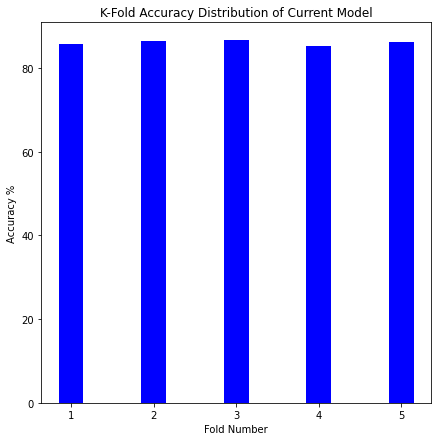


Avg accuracy for this model is: 86.03866592423799 %
Avg error for this model is: 13.961334075762016 %



(13.961334075762016,
 86.03866592423799,
 {'1': 85.75744497194648,
  '2': 86.49115235217954,
  '3': 86.57167530224525,
  '4': 85.23316062176166,
  '5': 86.13989637305698})

In [62]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=True, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None, tokenizer=MyLemmaTokenizer())

# # TFIDF normalizer
# tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# # Normalize with l2 so values are between 0 and 1
# training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
# training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# # Now select our best features based on chi squared evaluation 
# training_vectors4_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_normalized, Y)
# training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_tfidf_normalized, Y)

# run kfold
run_K_Fold_CrossValidation(training_vectors4, Y, nbExp, numFolds=5)


2) Lemmatization Experiment with Bernoulli NB

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 25897)
Current fold validation shape: (2317, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.1970484256744385
Accuracy for fold 1: 85.75744497194648%

Starting fold 2.....
Current fold training shape: (9265, 25897)
Current fold validation shape: (2317, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.154908895492554
Accuracy for fold 2: 86.49115235217954%

Starting fold 3.....
Current fold training shape: (9266, 25897)
Current fold validation shape: (2316, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.180292844772339
Accuracy for fold 3: 86.57167530224525%

Starting fold 4.....
Current fold training shape: (9266, 25897)
Current fold validation shape: (2316, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.464166641235352
Accuracy for fold 4: 85.23316062176166%

Starting fold 5.....
Current fold training shape: (9266, 25897)
Current fold validation shape: (2316, 25897)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.355318069458008
Accuracy for fold 5: 86.13989637305698%



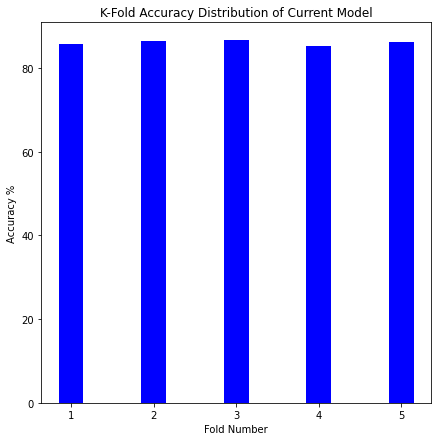


Avg accuracy for this model is: 86.03866592423799 %
Avg error for this model is: 13.961334075762016 %



(13.961334075762016,
 86.03866592423799,
 {'1': 85.75744497194648,
  '2': 86.49115235217954,
  '3': 86.57167530224525,
  '4': 85.23316062176166,
  '5': 86.13989637305698})

In [63]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=True, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None, tokenizer=MyLemmaTokenizer())

# # TFIDF normalizer
# tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# # Normalize with l2 so values are between 0 and 1
# training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
# training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# # Now select our best features based on chi squared evaluation 
# training_vectors4_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_normalized, Y)
# training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_tfidf_normalized, Y)

# run kfold
run_K_Fold_CrossValidation(training_vectors4, Y, nbExp, numFolds=5)


3) Raw data with no tokenizer using Bernoulli NB

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 33123)
Current fold validation shape: (2317, 33123)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.348634243011475
Accuracy for fold 1: 85.54164868364265%

Starting fold 2.....
Current fold training shape: (9265, 33123)
Current fold validation shape: (2317, 33123)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.171662330627441
Accuracy for fold 2: 87.13854121709107%

Starting fold 3.....
Current fold training shape: (9266, 33123)
Current fold validation shape: (2316, 33123)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.204285144805908
Accuracy for fold 3: 86.4853195164076%

Starting fold 4.....
Current fold training shape: (9266, 33123)
Current fold validation shape: (2316, 33123)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.201135635375977
Accuracy for fold 4: 85.75129533678756%

Starting fold 5.....
Current fold training shape: (9266, 33123)
Current fold validation shape: (2316, 33123)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.323915719985962
Accuracy for fold 5: 86.39896373056995%



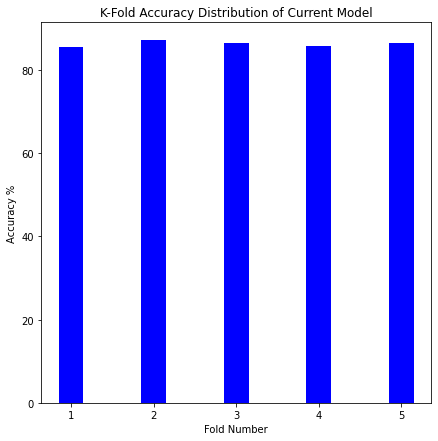


Avg accuracy for this model is: 86.26315369689976 %
Avg error for this model is: 13.736846303100233 %



(13.736846303100233,
 86.26315369689976,
 {'1': 85.54164868364265,
  '2': 87.13854121709107,
  '3': 86.4853195164076,
  '4': 85.75129533678756,
  '5': 86.39896373056995})

In [64]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=True, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# # TFIDF normalizer
# tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# # Normalize with l2 so values are between 0 and 1
# training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
# training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# # Now select our best features based on chi squared evaluation 
# training_vectors4_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_normalized, Y)
# training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_tfidf_normalized, Y)

# run kfold
run_K_Fold_CrossValidation(training_vectors4, Y, nbExp, numFolds=5)


4) Raw data with SKLearn feature selection (SelectKBest - Chi Squared Test)

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.2407402992248535
Accuracy for fold 1: 88.8649115235218%

Starting fold 2.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.202101945877075
Accuracy for fold 2: 89.59861890375485%

Starting fold 3.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.209667682647705
Accuracy for fold 3: 90.11226252158895%

Starting fold 4.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.184859037399292
Accuracy for fold 4: 89.72366148531951%

Starting fold 5.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.221644639968872
Accuracy for fold 5: 89.55094991364422%



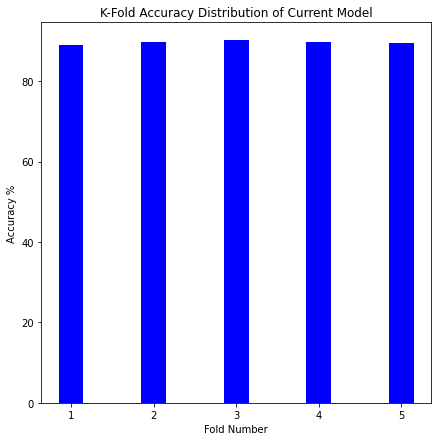


Avg accuracy for this model is: 89.57008086956586 %
Avg error for this model is: 10.429919130434135 %



(10.429919130434135,
 89.57008086956586,
 {'1': 88.8649115235218,
  '2': 89.59861890375485,
  '3': 90.11226252158895,
  '4': 89.72366148531951,
  '5': 89.55094991364422})

In [65]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=True, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# # TFIDF normalizer
# tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# # Normalize with l2 so values are between 0 and 1
# training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
# training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# # Now select our best features based on chi squared evaluation 
# training_vectors4_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_normalized, Y)
# training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_tfidf_normalized, Y)
training_vectors4_feature_selected = SelectKBest(chi2, k=8000).fit_transform(training_vectors4, Y)

# run kfold
run_K_Fold_CrossValidation(training_vectors4_feature_selected, Y, nbExp, numFolds=5)


5) Raw data and TFIDF normalization with SKLearn feature selection with different classifiers


Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.249483346939087
Accuracy for fold 1: 89.77125593439793%

Starting fold 2.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.230452299118042
Accuracy for fold 2: 90.41864479930946%

Starting fold 3.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.212558746337891
Accuracy for fold 3: 90.5440414507772%

Starting fold 4.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.23187518119812
Accuracy for fold 4: 90.67357512953367%

Starting fold 5.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.227933168411255
Accuracy for fold 5: 90.75993091537133%



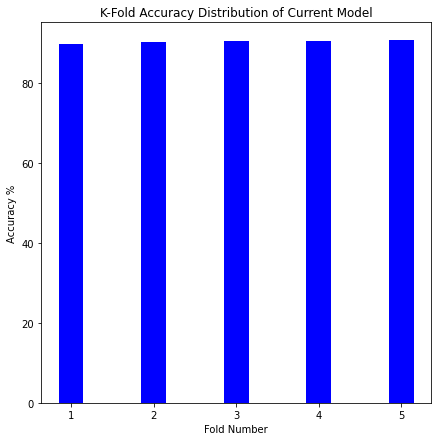


Avg accuracy for this model is: 90.43348964587793 %
Avg error for this model is: 9.566510354122082 %



(9.566510354122082,
 90.43348964587793,
 {'1': 89.77125593439793,
  '2': 90.41864479930946,
  '3': 90.5440414507772,
  '4': 90.67357512953367,
  '5': 90.75993091537133})

In [66]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=True, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# Now select our best features based on chi squared evaluation 
training_vectors4_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_normalized, Y)
training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_tfidf_normalized, Y)
# training_vectors4_feature_selected = SelectKBest(chi2, k=8000).fit_transform(training_vectors4, Y)

# run kfold
run_K_Fold_CrossValidation(training_vectors4_normalized_new, Y, nbExp, numFolds=5)


6) Raw data and TFIDF normalization with SKLearn feature selection with different classifiers and Stemming

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.232435703277588
Accuracy for fold 1: 88.9943892965041%

Starting fold 2.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.227808713912964
Accuracy for fold 2: 89.85757444971946%

Starting fold 3.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.196607828140259
Accuracy for fold 3: 90.06908462867013%

Starting fold 4.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.196943283081055
Accuracy for fold 4: 88.86010362694302%

Starting fold 5.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.174812316894531
Accuracy for fold 5: 89.07599309153713%



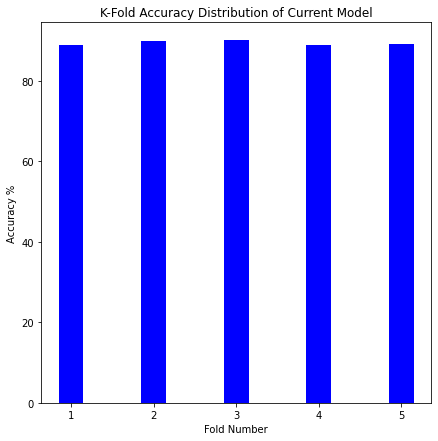


Avg accuracy for this model is: 89.37142901867477 %
Avg error for this model is: 10.628570981325234 %



(10.628570981325234,
 89.37142901867477,
 {'1': 88.9943892965041,
  '2': 89.85757444971946,
  '3': 90.06908462867013,
  '4': 88.86010362694302,
  '5': 89.07599309153713})

In [67]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=True, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None, tokenizer=MyStemTokenizer())

# TFIDF normalizer
tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# Now select our best features based on chi squared evaluation 
training_vectors4_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_normalized, Y)
training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_tfidf_normalized, Y)
# training_vectors4_feature_selected = SelectKBest(chi2, k=8000).fit_transform(training_vectors4, Y)

# run kfold
run_K_Fold_CrossValidation(training_vectors4_normalized_new, Y, nbExp, numFolds=5)


7) Bernouilli NB with best pipeline

In [68]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=True, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# Now select our best features based on chi squared evaluation 
training_vectors4_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_normalized, Y)
training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_tfidf_normalized, Y)
# training_vectors4_feature_selected = SelectKBest(chi2, k=8000).fit_transform(training_vectors4, Y)

# # run kfold
# run_K_Fold_CrossValidation(training_vectors4_normalized_new, Y, nbExp, numFolds=5)


Feature Selection for Bernouilli NB using Chi2

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 4000)
Current fold validation shape: (2317, 4000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.287423372268677
Accuracy for fold 1: 89.55545964609408%

Starting fold 2.....
Current fold training shape: (9265, 4000)
Current fold validation shape: (2317, 4000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.205758571624756
Accuracy for fold 2: 90.15968925334484%

Starting fold 3.....
Current fold training shape: (9266, 4000)
Current fold validation shape: (2316, 4000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.208489894866943
Accuracy for fold 3: 90.58721934369602%

Starting fold 4.....
Current fold training shape: (9266, 4000)
Current fold validation shape: (2316, 4000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.138349533081055
Accuracy for fold 4: 89.59412780656304%

Starting fold 5.....
Current fold training shape: (9266, 4000)
Current fold validation shape: (2316, 4000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.152954578399658
Accuracy for fold 5: 90.02590673575129%



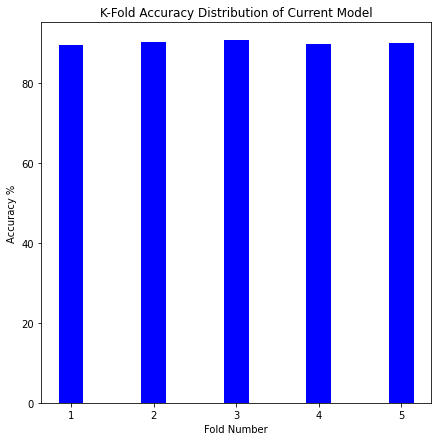


Avg accuracy for this model is: 89.98448055708985 %
Avg error for this model is: 10.015519442910147 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 5000)
Current fold validation shape: (2317, 5000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.247777223587036
Accuracy for fold 1: 89.85757444971946%

Starting fold 2.....
Current fold training shape: (9265, 5000)
Current fold validation shape: (2317, 5000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.240432024002075
Accuracy for fold 2: 89.943892965041%

Starting fold 3.....
Current fold training shape: (9266, 5000)
Current fold validation shape: (2316, 5000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.253273010253906
Accuracy for fold 3: 90.71675302245251%

Starting fold 4.....
Current fold training shape: (9266, 5000)
Current fold validation shape: (2316, 5000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.202971696853638
Accuracy for fold 4: 89.76683937823834%

Starting fold 5.....
Current fold training shape: (9266, 5000)
Current fold validation shape: (2316, 5000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.199300050735474
Accuracy for fold 5: 90.3713298791019%



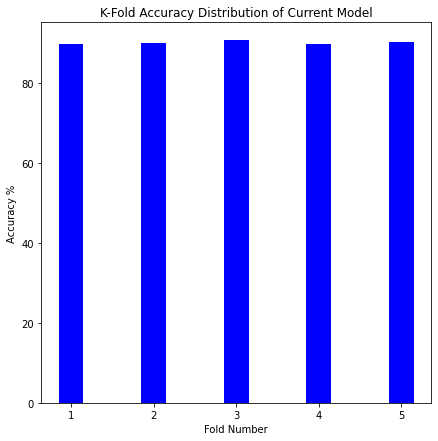


Avg accuracy for this model is: 90.13127793891064 %
Avg error for this model is: 9.868722061089354 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 6000)
Current fold validation shape: (2317, 6000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.29460334777832
Accuracy for fold 1: 89.90073370738023%

Starting fold 2.....
Current fold training shape: (9265, 6000)
Current fold validation shape: (2317, 6000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.19637656211853
Accuracy for fold 2: 89.943892965041%

Starting fold 3.....
Current fold training shape: (9266, 6000)
Current fold validation shape: (2316, 6000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.264249324798584
Accuracy for fold 3: 90.80310880829016%

Starting fold 4.....
Current fold training shape: (9266, 6000)
Current fold validation shape: (2316, 6000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.277374267578125
Accuracy for fold 4: 90.02590673575129%

Starting fold 5.....
Current fold training shape: (9266, 6000)
Current fold validation shape: (2316, 6000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.270679235458374
Accuracy for fold 5: 90.67357512953367%



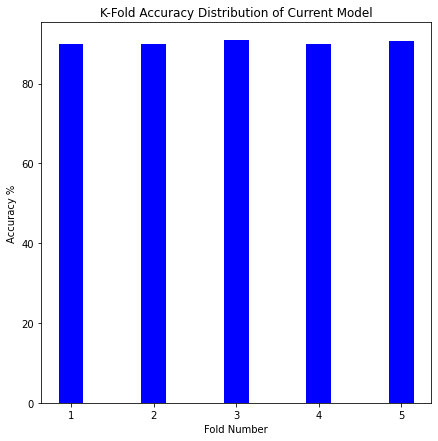


Avg accuracy for this model is: 90.26944346919927 %
Avg error for this model is: 9.73055653080073 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 7000)
Current fold validation shape: (2317, 7000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.245636701583862
Accuracy for fold 1: 89.98705222270176%

Starting fold 2.....
Current fold training shape: (9265, 7000)
Current fold validation shape: (2317, 7000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.23350191116333
Accuracy for fold 2: 90.28916702632715%

Starting fold 3.....
Current fold training shape: (9266, 7000)
Current fold validation shape: (2316, 7000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.268397331237793
Accuracy for fold 3: 90.80310880829016%

Starting fold 4.....
Current fold training shape: (9266, 7000)
Current fold validation shape: (2316, 7000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.366715669631958
Accuracy for fold 4: 90.45768566493955%

Starting fold 5.....
Current fold training shape: (9266, 7000)
Current fold validation shape: (2316, 7000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.212584018707275
Accuracy for fold 5: 90.71675302245251%



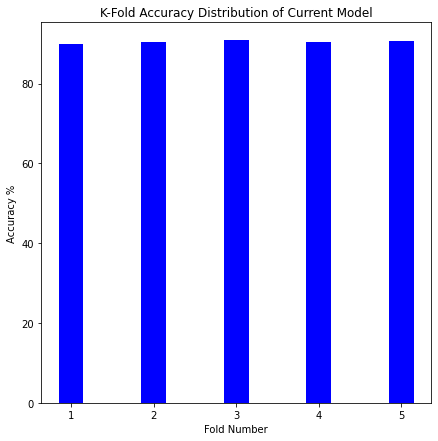


Avg accuracy for this model is: 90.45075334894223 %
Avg error for this model is: 9.549246651057775 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.208480358123779
Accuracy for fold 1: 89.77125593439793%

Starting fold 2.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.1654839515686035
Accuracy for fold 2: 90.41864479930946%

Starting fold 3.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.199089765548706
Accuracy for fold 3: 90.5440414507772%

Starting fold 4.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.181140422821045
Accuracy for fold 4: 90.67357512953367%

Starting fold 5.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.171780347824097
Accuracy for fold 5: 90.75993091537133%



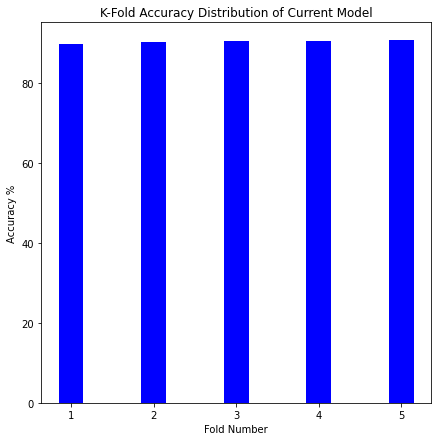


Avg accuracy for this model is: 90.43348964587793 %
Avg error for this model is: 9.566510354122082 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 9000)
Current fold validation shape: (2317, 9000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.206475496292114
Accuracy for fold 1: 89.68493741907639%

Starting fold 2.....
Current fold training shape: (9265, 9000)
Current fold validation shape: (2317, 9000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.182225227355957
Accuracy for fold 2: 90.28916702632715%

Starting fold 3.....
Current fold training shape: (9266, 9000)
Current fold validation shape: (2316, 9000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.185935735702515
Accuracy for fold 3: 90.71675302245251%

Starting fold 4.....
Current fold training shape: (9266, 9000)
Current fold validation shape: (2316, 9000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.19420313835144
Accuracy for fold 4: 90.5440414507772%

Starting fold 5.....
Current fold training shape: (9266, 9000)
Current fold validation shape: (2316, 9000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.208614826202393
Accuracy for fold 5: 90.84628670120898%



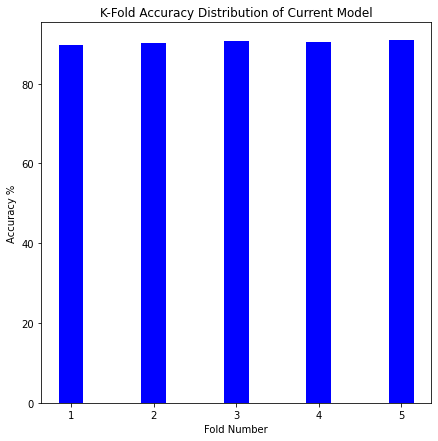


Avg accuracy for this model is: 90.41623712396844 %
Avg error for this model is: 9.583762876031553 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.275175094604492
Accuracy for fold 1: 89.85757444971946%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.312884092330933
Accuracy for fold 2: 90.37548554164869%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.32739520072937
Accuracy for fold 3: 90.63039723661485%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.224646329879761
Accuracy for fold 4: 90.50086355785838%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.270390510559082
Accuracy for fold 5: 90.67357512953367%



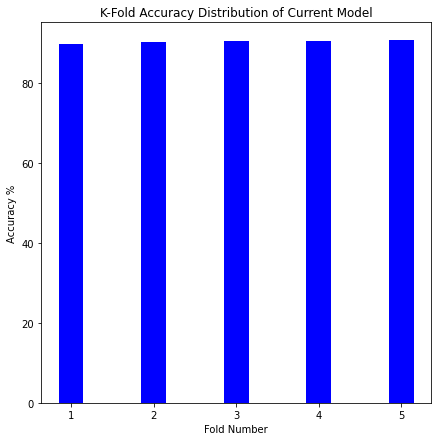


Avg accuracy for this model is: 90.40757918307501 %
Avg error for this model is: 9.592420816924989 %



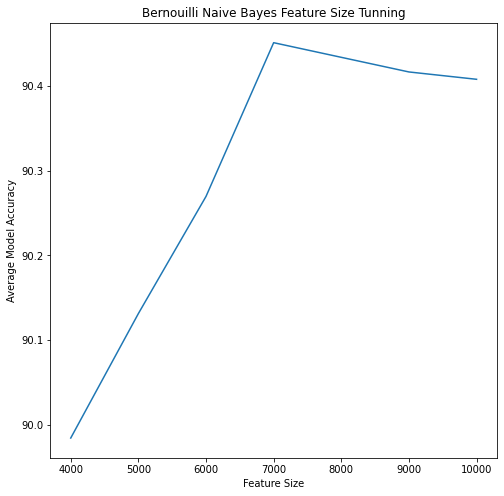

In [69]:
# Plotting feature size vs avgAccuracy
featureList = [4000,5000, 6000, 7000, 8000, 9000, 10000]
accuracies = []
for f in featureList:
  training_vectors4_normalized_new = SelectKBest(chi2, k=f).fit_transform(training_vectors4_normalized, Y)
  _,avgAccuracy,_ = run_K_Fold_CrossValidation(training_vectors4_normalized_new, Y, Bernoulli_NB(alpha=0.01), numFolds=5)
  accuracies.append(avgAccuracy)
plt.figure(figsize=(8,8))
plt.plot(featureList, accuracies)
plt.title("Bernouilli Naive Bayes Feature Size Tunning")
plt.xlabel("Feature Size")
plt.ylabel("Average Model Accuracy")
plt.show()

Hyper-parameter Tunning for Bernouilli NB

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.293760776519775
Accuracy for fold 1: 88.34700043159258%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.2507219314575195
Accuracy for fold 2: 89.08070781182563%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 7.575698614120483
Accuracy for fold 3: 89.89637305699482%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.219910383224487
Accuracy for fold 4: 88.47150259067358%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.866394758224487
Accuracy for fold 5: 90.02590673575129%



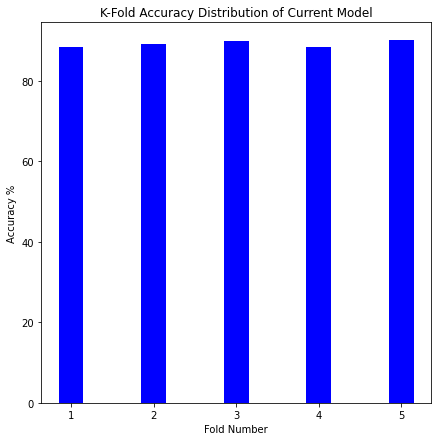


Avg accuracy for this model is: 89.16429812536758 %
Avg error for this model is: 10.83570187463242 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.322584629058838
Accuracy for fold 1: 88.82175226586104%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.355835437774658
Accuracy for fold 2: 89.59861890375485%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.249483346939087
Accuracy for fold 3: 90.19861830742659%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.268582105636597
Accuracy for fold 4: 88.94645941278065%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.2751336097717285
Accuracy for fold 5: 90.15544041450777%



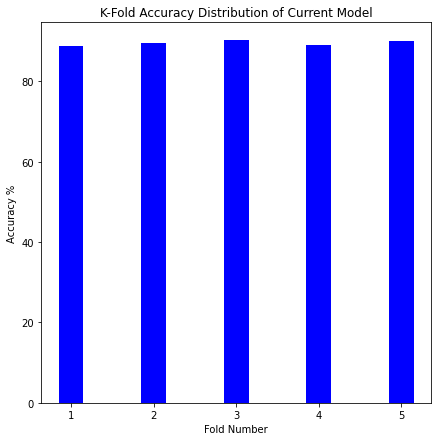


Avg accuracy for this model is: 89.54417786086618 %
Avg error for this model is: 10.45582213913382 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.320805311203003
Accuracy for fold 1: 89.2533448424687%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.27752423286438
Accuracy for fold 2: 89.90073370738023%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.263779401779175
Accuracy for fold 3: 90.19861830742659%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.280590772628784
Accuracy for fold 4: 89.33506044905009%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.2823405265808105
Accuracy for fold 5: 90.67357512953367%



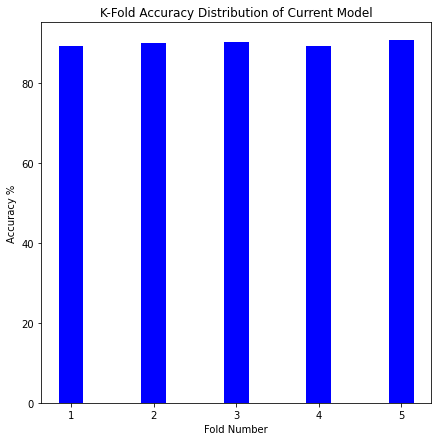


Avg accuracy for this model is: 89.87226648717186 %
Avg error for this model is: 10.127733512828144 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.324654579162598
Accuracy for fold 1: 89.77125593439793%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.260152339935303
Accuracy for fold 2: 90.24600776866637%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.2525975704193115
Accuracy for fold 3: 90.50086355785838%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.297358989715576
Accuracy for fold 4: 89.68048359240069%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.238515138626099
Accuracy for fold 5: 90.75993091537133%



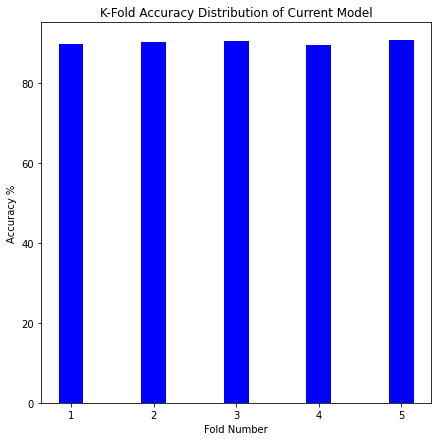


Avg accuracy for this model is: 90.19170835373896 %
Avg error for this model is: 9.80829164626106 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.262768745422363
Accuracy for fold 1: 89.90073370738023%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.32298731803894
Accuracy for fold 2: 90.72075960293483%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.370439291000366
Accuracy for fold 3: 90.58721934369602%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.326300859451294
Accuracy for fold 4: 90.32815198618307%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.216750860214233
Accuracy for fold 5: 90.88946459412782%



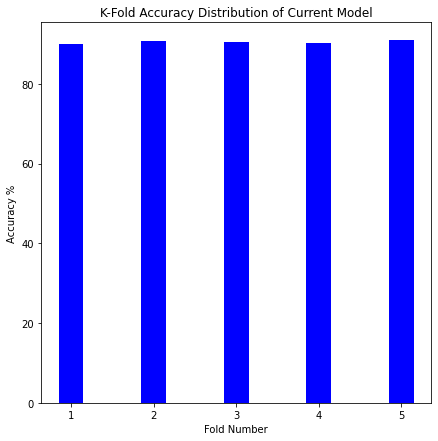


Avg accuracy for this model is: 90.4852658468644 %
Avg error for this model is: 9.514734153135606 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.28792667388916
Accuracy for fold 1: 89.85757444971946%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.237659215927124
Accuracy for fold 2: 90.37548554164869%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.254058361053467
Accuracy for fold 3: 90.63039723661485%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.256783962249756
Accuracy for fold 4: 90.50086355785838%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.2974841594696045
Accuracy for fold 5: 90.67357512953367%



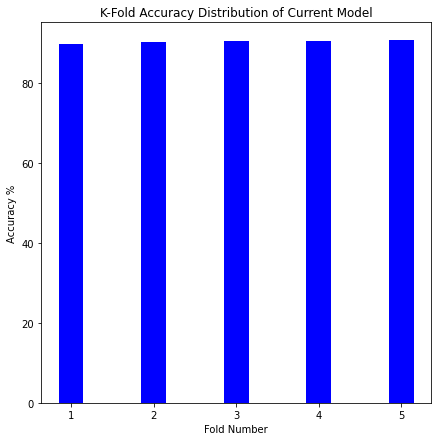


Avg accuracy for this model is: 90.40757918307501 %
Avg error for this model is: 9.592420816924989 %



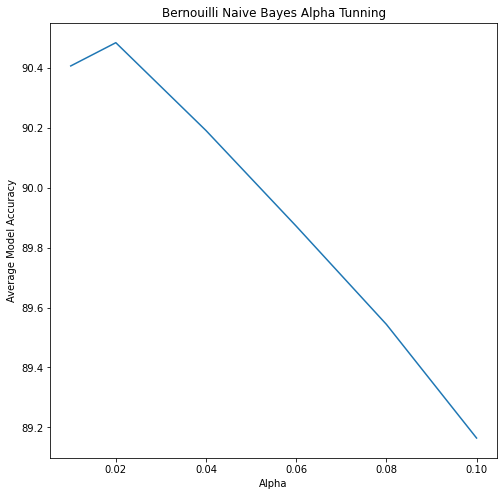

In [70]:
# Plotting alphas vs avg accuracy of the model
alpha = [0.1,0.08,0.06,0.04,0.02,0.01]
accuracies = []
for a in alpha:
  _,avgAccuracy,_ = run_K_Fold_CrossValidation(training_vectors4_normalized_new, Y, Bernoulli_NB(alpha=a), numFolds=5)
  accuracies.append(avgAccuracy)
plt.figure(figsize=(8,8))
plt.plot(alpha, accuracies)
plt.title("Bernouilli Naive Bayes Alpha Tunning")
plt.xlabel("Alpha")
plt.ylabel("Average Model Accuracy")
plt.show()


8) Bernouilli NB with best pipeline binary=False

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.246456861495972
Accuracy for fold 1: 89.81441519205869%

Starting fold 2.....
Current fold training shape: (9265, 8000)
Current fold validation shape: (2317, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.143727540969849
Accuracy for fold 2: 90.89339663357791%

Starting fold 3.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.199432373046875
Accuracy for fold 3: 90.88946459412782%

Starting fold 4.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.64151406288147
Accuracy for fold 4: 90.80310880829016%

Starting fold 5.....
Current fold training shape: (9266, 8000)
Current fold validation shape: (2316, 8000)
Starting the Predicting Function....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.nonzero is deprecated and will be removed in SciPy 2.0.0, use numpy.nonzero instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Time taken for predict function: 6.245970964431763
Accuracy for fold 5: 91.10535405872193%



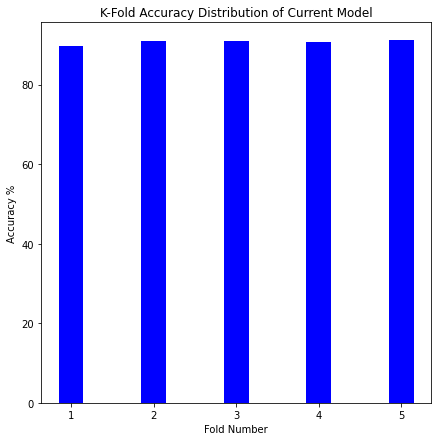


Avg accuracy for this model is: 90.7011478573553 %
Avg error for this model is: 9.2988521426447 %



(9.2988521426447,
 90.7011478573553,
 {'1': 89.81441519205869,
  '2': 90.89339663357791,
  '3': 90.88946459412782,
  '4': 90.80310880829016,
  '5': 91.10535405872193})

In [72]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# Now select our best features based on chi squared evaluation 
training_vectors4_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_normalized, Y)
training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8000).fit_transform(training_vectors4_tfidf_normalized, Y)
# training_vectors4_feature_selected = SelectKBest(chi2, k=8000).fit_transform(training_vectors4, Y)

# run kfold
run_K_Fold_CrossValidation(training_vectors4_tfidf_normalized_new, Y, nbExp, numFolds=5)


9) Multinomial NB with best pipeline

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 7500)
Current fold validation shape: (2317, 7500)
Accuracy for fold 1: 90.28916702632715%

Starting fold 2.....
Current fold training shape: (9265, 7500)
Current fold validation shape: (2317, 7500)
Accuracy for fold 2: 91.06603366422098%

Starting fold 3.....
Current fold training shape: (9266, 7500)
Current fold validation shape: (2316, 7500)
Accuracy for fold 3: 91.58031088082902%

Starting fold 4.....
Current fold training shape: (9266, 7500)
Current fold validation shape: (2316, 7500)
Accuracy for fold 4: 91.66666666666666%

Starting fold 5.....
Current fold training shape: (9266, 7500)
Current fold validation shape: (2316, 7500)
Accuracy for fold 5: 91.58031088082902%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

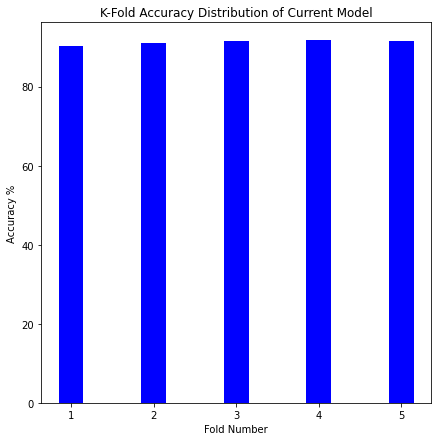


Avg accuracy for this model is: 91.23649782377457 %
Avg error for this model is: 8.763502176225435 %



(8.763502176225435,
 91.23649782377457,
 {'1': 90.28916702632715,
  '2': 91.06603366422098,
  '3': 91.58031088082902,
  '4': 91.66666666666666,
  '5': 91.58031088082902})

In [73]:
# Vectorizer object for linear svc
myVectorizer4 = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer4 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer4 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors4 = myVectorizer4.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors4_tfidf_normalized = tfidfNormalizer4.fit_transform(training_vectors4)
training_vectors4_normalized = normalizer4.fit_transform(training_vectors4)

# Now select our best features based on chi squared evaluation 
training_vectors4_normalized_new = SelectKBest(chi2, k=7500).fit_transform(training_vectors4_normalized, Y)
training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=8500).fit_transform(training_vectors4_tfidf_normalized, Y)

run_K_Fold_CrossValidation(training_vectors4_normalized_new, Y, mbExp, numFolds=5)

Feature Selection using Chi2 for Multinomial and SVC


Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 4000)
Current fold validation shape: (2317, 4000)
Accuracy for fold 1: 88.90807078118257%

Starting fold 2.....
Current fold training shape: (9265, 4000)
Current fold validation shape: (2317, 4000)
Accuracy for fold 2: 90.15968925334484%

Starting fold 3.....
Current fold training shape: (9266, 4000)
Current fold validation shape: (2316, 4000)
Accuracy for fold 3: 90.45768566493955%

Starting fold 4.....
Current fold training shape: (9266, 4000)
Current fold validation shape: (2316, 4000)
Accuracy for fold 4: 89.46459412780656%

Starting fold 5.....
Current fold training shape: (9266, 4000)
Current fold validation shape: (2316, 4000)
Accuracy for fold 5: 89.93955094991365%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

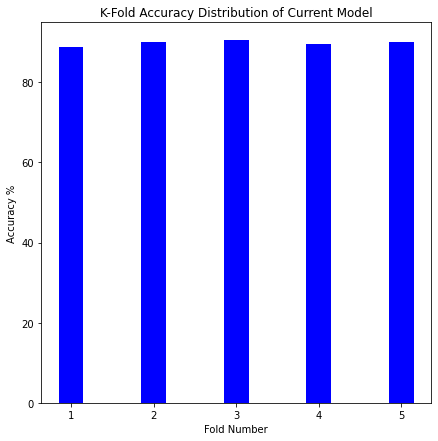


Avg accuracy for this model is: 89.78591815543743 %
Avg error for this model is: 10.214081844562566 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 5000)
Current fold validation shape: (2317, 5000)
Accuracy for fold 1: 89.21018558480795%

Starting fold 2.....
Current fold training shape: (9265, 5000)
Current fold validation shape: (2317, 5000)
Accuracy for fold 2: 91.23867069486404%

Starting fold 3.....
Current fold training shape: (9266, 5000)
Current fold validation shape: (2316, 5000)
Accuracy for fold 3: 90.63039723661485%

Starting fold 4.....
Current fold training shape: (9266, 5000)
Current fold validation shape: (2316, 5000)
Accuracy for fold 4: 89.89637305699482%

Starting fold 5.....
Current fold training shape: (9266, 5000)
Current fold validation shape: (2316, 5000)
Accuracy for fold 5: 90.45768566493955%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

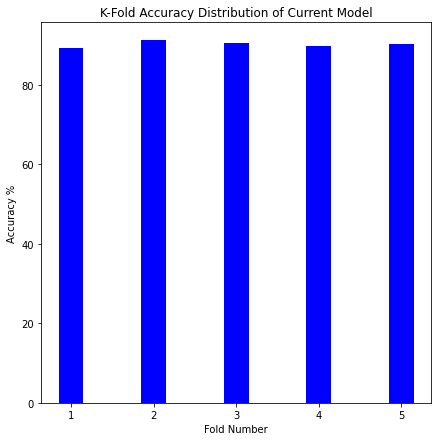


Avg accuracy for this model is: 90.28666244764425 %
Avg error for this model is: 9.713337552355759 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 6000)
Current fold validation shape: (2317, 6000)
Accuracy for fold 1: 89.08070781182563%

Starting fold 2.....
Current fold training shape: (9265, 6000)
Current fold validation shape: (2317, 6000)
Accuracy for fold 2: 91.36814846784635%

Starting fold 3.....
Current fold training shape: (9266, 6000)
Current fold validation shape: (2316, 6000)
Accuracy for fold 3: 90.93264248704664%

Starting fold 4.....
Current fold training shape: (9266, 6000)
Current fold validation shape: (2316, 6000)
Accuracy for fold 4: 90.71675302245251%

Starting fold 5.....
Current fold training shape: (9266, 6000)
Current fold validation shape: (2316, 6000)
Accuracy for fold 5: 90.88946459412782%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

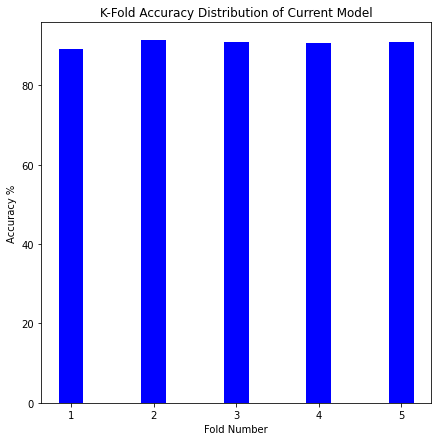


Avg accuracy for this model is: 90.59754327665978 %
Avg error for this model is: 9.402456723340212 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 7000)
Current fold validation shape: (2317, 7000)
Accuracy for fold 1: 89.46914113077256%

Starting fold 2.....
Current fold training shape: (9265, 7000)
Current fold validation shape: (2317, 7000)
Accuracy for fold 2: 91.28182995252482%

Starting fold 3.....
Current fold training shape: (9266, 7000)
Current fold validation shape: (2316, 7000)
Accuracy for fold 3: 90.93264248704664%

Starting fold 4.....
Current fold training shape: (9266, 7000)
Current fold validation shape: (2316, 7000)
Accuracy for fold 4: 90.71675302245251%

Starting fold 5.....
Current fold training shape: (9266, 7000)
Current fold validation shape: (2316, 7000)
Accuracy for fold 5: 90.97582037996546%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

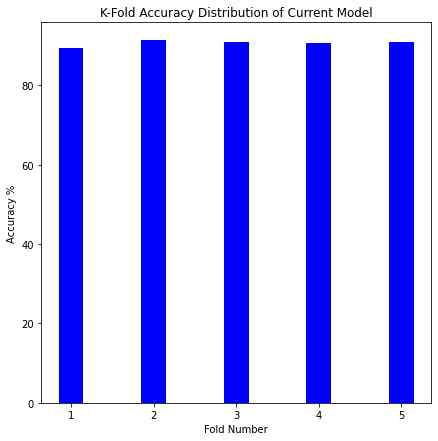


Avg accuracy for this model is: 90.6752373945524 %
Avg error for this model is: 9.324762605447606 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 8500)
Current fold validation shape: (2317, 8500)
Accuracy for fold 1: 89.33966335779024%

Starting fold 2.....
Current fold training shape: (9265, 8500)
Current fold validation shape: (2317, 8500)
Accuracy for fold 2: 91.32498921018558%

Starting fold 3.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 3: 90.93264248704664%

Starting fold 4.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 4: 90.45768566493955%

Starting fold 5.....
Current fold training shape: (9266, 8500)
Current fold validation shape: (2316, 8500)
Accuracy for fold 5: 90.88946459412782%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

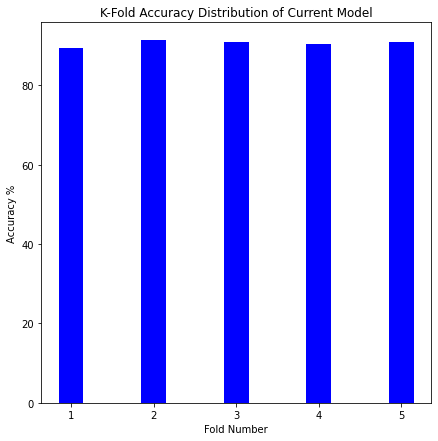


Avg accuracy for this model is: 90.58888906281797 %
Avg error for this model is: 9.411110937182036 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 9000)
Current fold validation shape: (2317, 9000)
Accuracy for fold 1: 89.33966335779024%

Starting fold 2.....
Current fold training shape: (9265, 9000)
Current fold validation shape: (2317, 9000)
Accuracy for fold 2: 91.06603366422098%

Starting fold 3.....
Current fold training shape: (9266, 9000)
Current fold validation shape: (2316, 9000)
Accuracy for fold 3: 90.75993091537133%

Starting fold 4.....
Current fold training shape: (9266, 9000)
Current fold validation shape: (2316, 9000)
Accuracy for fold 4: 90.28497409326425%

Starting fold 5.....
Current fold training shape: (9266, 9000)
Current fold validation shape: (2316, 9000)
Accuracy for fold 5: 90.75993091537133%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

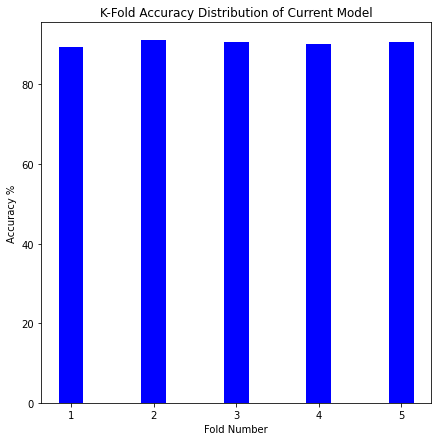


Avg accuracy for this model is: 90.44210658920363 %
Avg error for this model is: 9.557893410796373 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 1: 89.29650410012948%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 2: 91.10919292188174%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 3: 90.67357512953367%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 4: 90.19861830742659%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 5: 90.84628670120898%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

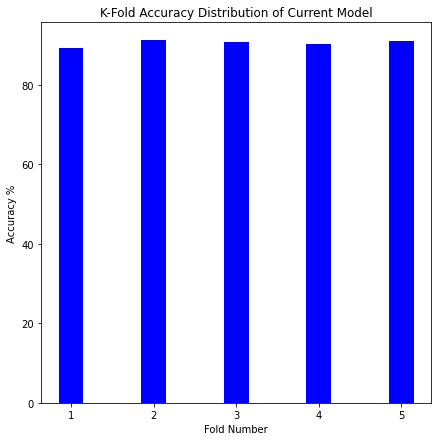


Avg accuracy for this model is: 90.42483543203609 %
Avg error for this model is: 9.575164567963906 %



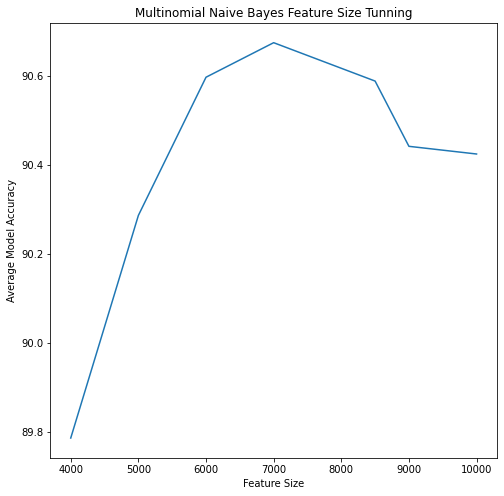

In [74]:
# Plotting feature size vs avgAccuracy
featureList = [4000,5000, 6000, 7000, 8500, 9000, 10000]
accuracies = []
for f in featureList:
  training_vectors4_tfidf_normalized_new = SelectKBest(chi2, k=f).fit_transform(training_vectors4_tfidf_normalized, Y)
  _,avgAccuracy,_ = run_K_Fold_CrossValidation(training_vectors4_tfidf_normalized_new, Y, MultinomialNB(alpha=0.04), numFolds=5)
  accuracies.append(avgAccuracy)
plt.figure(figsize=(8,8))
plt.plot(featureList, accuracies)
plt.title("Multinomial Naive Bayes Feature Size Tunning")
plt.xlabel("Feature Size")
plt.ylabel("Average Model Accuracy")
plt.show()

Hyper-parameter Tunning for Multinomial NB

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 1: 88.64911523521796%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 2: 90.46180405697022%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 3: 90.11226252158895%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 4: 89.55094991364422%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 5: 90.19861830742659%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

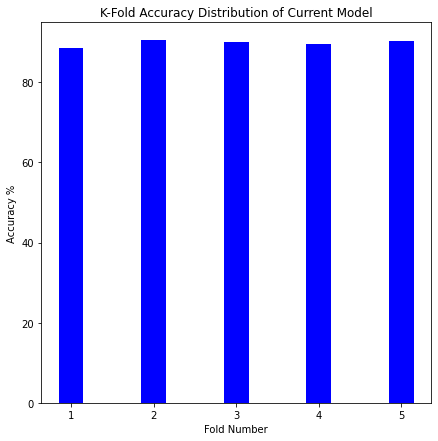


Avg accuracy for this model is: 89.7945500069696 %
Avg error for this model is: 10.205449993030413 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 1: 89.03754855416487%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 2: 90.59128182995254%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 3: 90.24179620034542%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 4: 89.72366148531951%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 5: 90.41450777202073%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

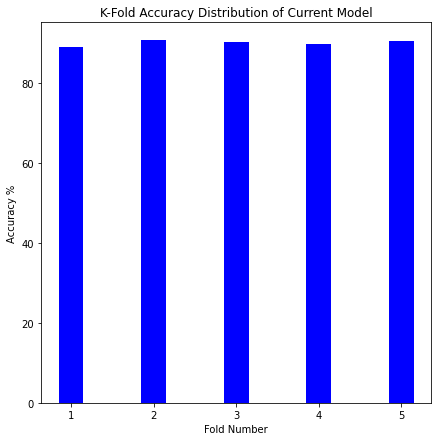


Avg accuracy for this model is: 90.0017591683606 %
Avg error for this model is: 9.998240831639388 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 1: 89.12386706948641%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 2: 90.7639188605956%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 3: 90.41450777202073%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 4: 90.06908462867013%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 5: 90.58721934369602%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

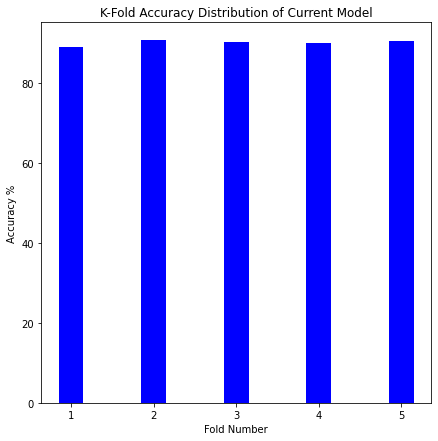


Avg accuracy for this model is: 90.19171953489376 %
Avg error for this model is: 9.808280465106225 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 1: 89.29650410012948%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 2: 91.10919292188174%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 3: 90.67357512953367%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 4: 90.19861830742659%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 5: 90.84628670120898%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

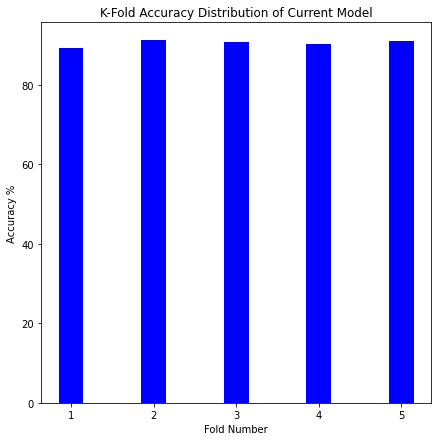


Avg accuracy for this model is: 90.42483543203609 %
Avg error for this model is: 9.575164567963906 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 1: 89.59861890375485%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 2: 91.06603366422098%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 3: 90.63039723661485%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 4: 90.3713298791019%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 5: 90.88946459412782%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

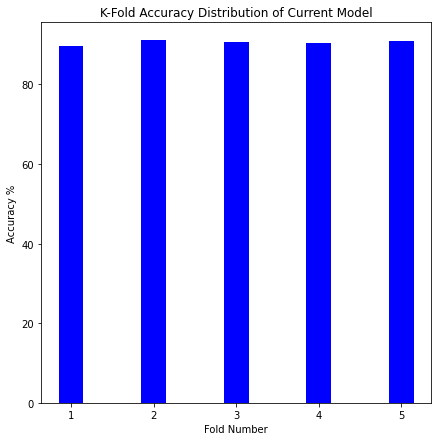


Avg accuracy for this model is: 90.51116885556408 %
Avg error for this model is: 9.488831144435917 %

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 1: 89.81441519205869%

Starting fold 2.....
Current fold training shape: (9265, 10000)
Current fold validation shape: (2317, 10000)
Accuracy for fold 2: 90.93655589123867%

Starting fold 3.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 3: 90.67357512953367%

Starting fold 4.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 4: 90.19861830742659%

Starting fold 5.....
Current fold training shape: (9266, 10000)
Current fold validation shape: (2316, 10000)
Accuracy for fold 5: 90.75993091537133%



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

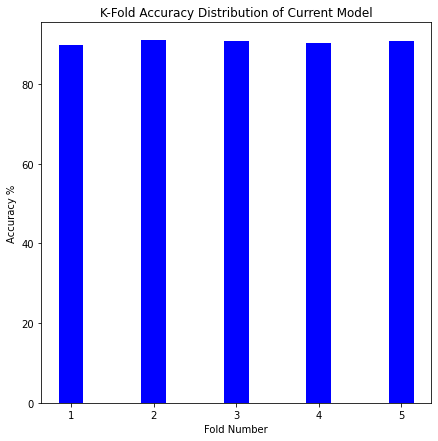


Avg accuracy for this model is: 90.4766190871258 %
Avg error for this model is: 9.523380912874211 %



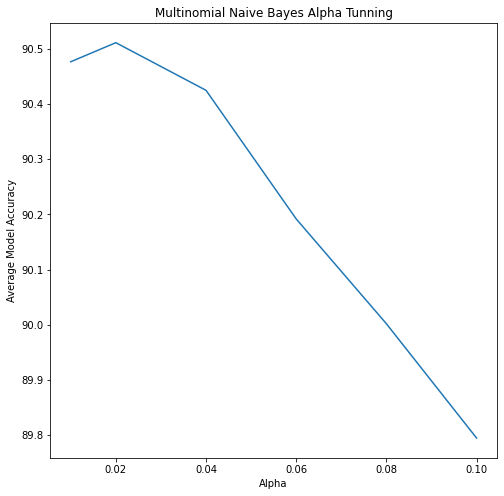

In [75]:
# Plotting alphas vs avg accuracy of the model
alpha = [0.1,0.08,0.06,0.04,0.02,0.01]
accuracies = []
for a in alpha:
  _,avgAccuracy,_ = run_K_Fold_CrossValidation(training_vectors4_tfidf_normalized_new, Y, MultinomialNB(alpha=a), numFolds=5)
  accuracies.append(avgAccuracy)
plt.figure(figsize=(8,8))
plt.plot(alpha, accuracies)
plt.title("Multinomial Naive Bayes Alpha Tunning")
plt.xlabel("Alpha")
plt.ylabel("Average Model Accuracy")
plt.show()


10) LinearSVC with best pipeline

Number of splitting iterations: 5

Starting fold 1.....
Current fold training shape: (9265, 15000)
Current fold validation shape: (2317, 15000)
Accuracy for fold 1: 88.9943892965041%

Starting fold 2.....
Current fold training shape: (9265, 15000)
Current fold validation shape: (2317, 15000)
Accuracy for fold 2: 89.51230038843332%

Starting fold 3.....
Current fold training shape: (9266, 15000)
Current fold validation shape: (2316, 15000)
Accuracy for fold 3: 90.02590673575129%

Starting fold 4.....
Current fold training shape: (9266, 15000)
Current fold validation shape: (2316, 15000)
Accuracy for fold 4: 88.60103626943005%

Starting fold 5.....
Current fold training shape: (9266, 15000)
Current fold validation shape: (2316, 15000)
Accuracy for fold 5: 89.59412780656304%



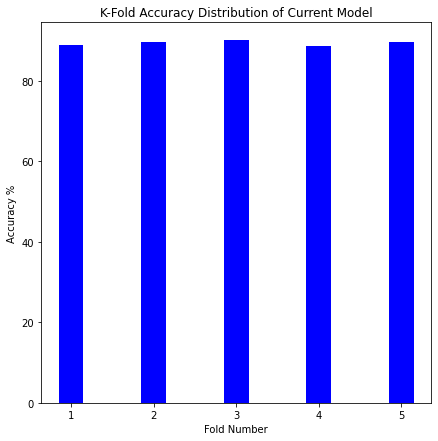


Avg accuracy for this model is: 89.34555209933636 %
Avg error for this model is: 10.65444790066364 %



(10.65444790066364,
 89.34555209933636,
 {'1': 88.9943892965041,
  '2': 89.51230038843332,
  '3': 90.02590673575129,
  '4': 88.60103626943005,
  '5': 89.59412780656304})

In [76]:
# Vectorizer object for linear svc
myVectorizer3 = CountVectorizer(binary=False, max_df=1.0, min_df=0.0, stop_words=myStopWords, ngram_range=(1,1), max_features=None)

# TFIDF normalizer
tfidfNormalizer3 = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Normalizer object for  linear svc
normalizer3 = Normalizer()

# Create our non binary training vector of word frequencies
training_vectors3 = myVectorizer3.fit_transform(Xtraining)

# Normalize with l2 so values are between 0 and 1
training_vectors3_tfidf_normalized = tfidfNormalizer3.fit_transform(training_vectors3)
training_vectors3_normalized = normalizer3.fit_transform(training_vectors3)

# Now select our best features based on chi squared evaluation 
training_vectors3_normalized_new = SelectKBest(chi2, k=15000).fit_transform(training_vectors3_normalized, Y)
training_vectors3_tfidf_normalized_new = SelectKBest(chi2, k=15000).fit_transform(training_vectors3_tfidf_normalized, Y)

Ysvc = np.reshape(Y, (Y.shape[0],))
run_K_Fold_CrossValidation(training_vectors3_tfidf_normalized_new, Ysvc, linearsvc, numFolds=5)